# Swarm Intelligence Algorithms: ACO vs PSO
## Multi-Agent Task Scheduling Comparison

Perbandingan algoritma Ant Colony Optimization (ACO) dan Particle Swarm Optimization (PSO) untuk penjadwalan tugas multi-agent.

In [3]:
# Import libraries yang dibutuhkan
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, Layout
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproduksibilitas
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print(f"Random seed set to: {RANDOM_SEED}")

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Random seed set to: 42


In [4]:
# Implementasi Algoritma ACO dan PSO untuk Penjadwalan Tugas Multi-Agen
class ACO_MultiAgent_Scheduler:
    """Ant Colony Optimization for Multi-Agent Task Scheduling"""
    # Buat inisialisasi kelas dengan parameter yang diperlukan
    def __init__(self, tasks, cost_function, heuristic_function,
                 agents=None, num_default_agents=3,
                 task_id_col='id', agent_id_col='id',
                 n_ants=10, n_iterations=100, alpha=1.0, beta=2.0,
                 evaporation_rate=0.5, pheromone_deposit=100.0,
                 enable_dependencies=False, random_seed=None):

        # Ubah input DataFrame menjadi list of dictionaries jika diperlukan
        if isinstance(tasks, pd.DataFrame):
            self.tasks = tasks.to_dict('records')
        else:
            self.tasks = tasks

        if isinstance(agents, pd.DataFrame):
            self.agents = agents.to_dict('records')
        else:
            self.agents = agents

        # Konfigurasi inti
        self.cost_function = cost_function
        self.heuristic_function = heuristic_function
        self.task_id_col = task_id_col
        self.agent_id_col = agent_id_col
        self.enable_dependencies = enable_dependencies

        # Default agents jika tidak disediakan
        if not self.agents:
            self.agents = [{self.agent_id_col: f'DefaultAgent-{i+1}'} for i in range(num_default_agents)]

        # Parameter algoritma
        self.n_tasks = len(self.tasks)
        self.n_agents = len(self.agents)
        # Tangani kasus di mana n_tasks adalah 0 untuk mencegah kesalahan
        if self.n_tasks == 0:
            print("Warning: No tasks provided. ACO scheduler will not run.")
            self.n_ants = 0
            self.n_iterations = 0
        else:
            self.n_ants = n_ants
            self.n_iterations = n_iterations

        # ACO parameters
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.pheromone_deposit = pheromone_deposit
        self.prioritize_balance = True

        # Pemetaan tugas untuk indeks cepat
        self.task_map = {str(task[self.task_id_col]): i for i, task in enumerate(self.tasks)}
        self.rev_task_map = {i: str(task[self.task_id_col]) for i, task in enumerate(self.tasks)}

        # Penanganan ketergantungan
        self.dependencies = self._parse_dependencies() if self.enable_dependencies and self.n_tasks > 0 else {}
        self.dependency_graph = self._build_dependency_graph() if self.enable_dependencies and self.n_tasks > 0 else None

        # Periksa ketergantungan melingkar
        if self.enable_dependencies and self.n_tasks > 0 and self._detect_circular_dependencies():
            print("Warning: Circular dependencies detected. Algorithm will use fallback mechanisms.")

        # Set random seed for reproduksibilitas
        if random_seed is not None:
            np.random.seed(random_seed)
            random.seed(random_seed)

        # Inisialisasi pheromone dan heuristic matrices
        # Inisialisasi hanya jika ada tugas
        if self.n_tasks > 0:
            self.pheromones = np.ones((self.n_tasks, self.n_tasks))
            self.heuristics = self._calculate_heuristics()
        else:
            self.pheromones = np.array([[]]) # Empty array
            self.heuristics = np.array([[]]) # Empty array

        # Pelacakan solusi terbaik
        self.best_schedule = None
        self.best_cost = float('inf')
        self.best_load_balance_index = float('inf')

        # Progress tracking
        self.iteration_history = []

    # Fungsi bantu untuk menghitung load balance index
    def _calculate_load_balance_index(self, agent_finish_times):
        """Calculate load balance index (lower = better balance)"""
        # Jika tidak ada agen, kembalikan 0
        times = list(agent_finish_times.values())
        if len(times) <= 1:
            return 0.0
        # Hitung mean waktu selesai
        mean_time = sum(times) / len(times)
        if mean_time == 0:
            return 0.0

        # Standar deviasi dinormalisasi dengan mean
        variance = sum((t - mean_time) ** 2 for t in times) / len(times)
        std_dev = variance ** 0.5
        load_balance_index = std_dev / mean_time
        return load_balance_index
    
    # Deteksi ketergantungan melingkar
    def _detect_circular_dependencies(self):
        """Detect circular dependencies using DFS"""
        if not self.enable_dependencies or self.n_tasks == 0:
            return False

        # Gunakan DFS (Depth-First Search) untuk mendeteksi siklus
        visited = set()
        rec_stack = set()

        # Fungsi rekursif untuk mendeteksi siklus
        def has_cycle(task_id):
            if task_id in rec_stack:
                return True
            if task_id in visited:
                return False

            visited.add(task_id)
            rec_stack.add(task_id)
            # Periksa semua ketergantungan
            for dep_id in self.dependencies.get(task_id, []):
                if has_cycle(dep_id):
                    return True
            # Hapus dari recursion stack setelah pemeriksaan
            rec_stack.remove(task_id)
            return False
        # Periksa semua tugas untuk siklus
        for task_id in self.dependencies:
            if task_id not in visited:
                if has_cycle(task_id):
                    return True
        return False
    # Fungsi bantu untuk mengurai ketergantungan tugas
    def _parse_dependencies(self):
        """Parse task dependencies with robust field handling"""
        # Inisialisasi dictionary ketergantungan
        dependencies = {}
        # Tangani kasus di mana tidak ada tugas
        if self.n_tasks == 0:
            return dependencies
        # Iterasi melalui semua tugas
        for task in self.tasks:
            task_id = str(task[self.task_id_col])

            # Cari field ketergantungan dari berbagai nama yang mungkin
            deps = None
            for field in ['dependencies', 'depends_on', 'prerequisites', 'requires', 'Dependencies']:
                if field in task and task[field] is not None:
                    deps = task[field]
                    break

            # Proses nilai ketergantungan berdasarkan tipe data
            if deps:
                if isinstance(deps, str):
                    if deps.strip() == '' or deps.lower() in ['null', 'nan', 'none']:
                        deps = []
                    else:
                        deps = [str(d).strip() for d in deps.replace(';', ',').split(',')
                               if d.strip() and str(d).lower() not in ['null', 'nan', 'none', '']]
                elif isinstance(deps, (list, tuple)):
                    deps = [str(d).strip() for d in deps
                           if d is not None and str(d).strip() and str(d).lower() not in ['null', 'nan', 'none']]
                elif deps is not None:
                    dep_str = str(deps).strip()
                    deps = [dep_str] if dep_str and dep_str.lower() not in ['null', 'nan', 'none'] else []
                else:
                    deps = []
            else:
                deps = []

            dependencies[task_id] = deps
        return dependencies

    # Membangun grafik ketergantungan
    def _build_dependency_graph(self):
        """Build dependency graph for validation"""
        if self.n_tasks == 0:
            return {}
        graph = {}
        for task_id in self.dependencies:
            graph[task_id] = self.dependencies[task_id]
        return graph

    # Periksa apakah ketergantungan terpenuhi   
    def _is_dependency_satisfied(self, task_id, completed_tasks):
        """Check if all dependencies are completed"""
        if not self.enable_dependencies or task_id not in self.dependencies:
            return True
        # Periksa setiap ketergantungan
        for dep_id in self.dependencies[task_id]:
            if dep_id not in completed_tasks:
                return False
        return True

    # Dapatkan tugas yang siap dikerjakan
    def _get_ready_tasks(self, remaining_tasks, completed_tasks):
        """Get tasks whose dependencies are satisfied"""
        if not self.enable_dependencies:
            return remaining_tasks

        ready_tasks = []
        # Periksa setiap tugas yang tersisa
        for task_idx in remaining_tasks:
            task_id = str(self.rev_task_map[task_idx])
            if self._is_dependency_satisfied(task_id, completed_tasks):
                ready_tasks.append(task_idx)
        return ready_tasks

    # Hitung matriks heuristik
    def _calculate_heuristics(self):
        if self.n_tasks == 0:
            return np.array([[]])
        # Hitung matriks heuristik berdasarkan fungsi heuristik
        heuristics = np.zeros((self.n_tasks, self.n_tasks))
        for i in range(self.n_tasks):
            for j in range(self.n_tasks):
                if i != j:
                    heuristics[i, j] = self.heuristic_function(self.tasks[j])
        return heuristics

    # Konstruk solusi dengan penanganan ketergantungan
    def _construct_solution(self):
        """Enhanced solution construction with dependency handling"""
        if self.n_tasks == 0:
            return [] # Kembalikan tur kosong jika tidak ada tugas

        tour = []
        remaining_tasks = set(range(self.n_tasks))
        completed_task_ids = set()
        current_task_idx = None

        # Batas iterasi untuk mencegah loop tak berujung
        max_iterations = self.n_tasks * 2
        iteration_count = 0

        # Bangun tur sampai semua tugas selesai
        while remaining_tasks and iteration_count < max_iterations:
            iteration_count += 1

            # Dapatkan tugas yang siap dikerjakan
            ready_tasks = self._get_ready_tasks(list(remaining_tasks), completed_task_ids)

            if not ready_tasks:
                # Fallback: pilih tugas dengan ketergantungan minimum
                min_deps = float('inf')
                task_to_force = -1
                # Cari tugas dengan ketergantungan minimum
                for task_idx in remaining_tasks:
                    task_id = self.rev_task_map[task_idx]
                    deps = self.dependencies.get(task_id, [])
                    unsatisfied_deps = len([d for d in deps if d not in completed_task_ids])
                    if unsatisfied_deps < min_deps:
                        min_deps = unsatisfied_deps
                        task_to_force = task_idx
                # Paksa pilih tugas tersebut
                if task_to_force != -1:
                    ready_tasks = [task_to_force]
                else:
                    break

            # Jika tugas saat ini tidak siap, pilih acak dari tugas siap
            if current_task_idx is None or current_task_idx not in ready_tasks:
                if ready_tasks: # Ensure ready_tasks is not empty before choosing
                    next_task_idx = random.choice(ready_tasks)
                else:
                    break # No ready tasks, break
            else:
                # Gunakan pheromone dan heuristik untuk memilih tugas berikutnya
                probabilities = self._calculate_probabilities(current_task_idx, ready_tasks)
                if len(ready_tasks) == 1:
                    next_task_idx = ready_tasks[0]
                elif ready_tasks: # Pastikan ready_tasks tidak kosong sebelum memilih
                    next_task_idx = np.random.choice(ready_tasks, p=probabilities)
                else:
                     break # No ready tasks, break

            # Perbarui tur dan status tugas
            tour.append(next_task_idx)
            remaining_tasks.remove(next_task_idx)
            completed_task_ids.add(self.rev_task_map[next_task_idx])
            current_task_idx = next_task_idx

        # Tambahkan tugas yang tersisa (jika ada) sebagai tindakan pencegahan
        if remaining_tasks:
            tour.extend(sorted(list(remaining_tasks)))

        return tour

    # Hitung probabilitas untuk memilih tugas berikutnya
    def _calculate_probabilities(self, current_task_idx, unvisited_tasks):
        if not unvisited_tasks: # Handle empty unvisited tasks
            return np.array([])

        # Hitung nilai pheromone dan heuristik
        pheromone_values = self.pheromones[current_task_idx, unvisited_tasks] ** self.alpha
        heuristic_values = self.heuristics[current_task_idx, unvisited_tasks] ** self.beta
        desirability = pheromone_values * heuristic_values
        total_desirability = np.sum(desirability)

        # Normalisasi probabilitas
        if total_desirability == 0:
            return np.ones(len(unvisited_tasks)) / len(unvisited_tasks)
        probabilities = desirability / total_desirability
        return probabilities

    # Tugaskan tugas ke agen dengan mempertimbangkan ketergantungan dan load balancing
    def _assign_to_agents(self, task_sequence_indices):
        """Enhanced agent assignment with dependency and load balancing consideration"""
        if not self.agents or not task_sequence_indices: # Handle empty agents or task sequence
            return [], 0, 0.0

        # Inisialisasi variabel untuk penjadwalan
        agent_finish_times = {agent[self.agent_id_col]: 0 for agent in self.agents}
        task_finish_times = {}  # Optimasi: Gunakan dict untuk lookup lebih cepat
        schedule = []

        # Iterasi melalui urutan tugas
        for task_idx in task_sequence_indices:
            task = self.tasks[task_idx]
            task_id = str(task[self.task_id_col])
            duration = task.get('length', task.get('duration', 1))

            # Temukan agen terbaik untuk tugas ini
            best_agent_id = self._find_best_agent(agent_finish_times, duration)

            # Hitung waktu mulai berdasarkan ketergantungan
            dependency_finish_time = 0
            if self.enable_dependencies and task_id in self.dependencies:
                for dep_id in self.dependencies[task_id]:
                    # Optimasi: Gunakan dict untuk lookup lebih cepat
                    dependency_finish_time = max(dependency_finish_time, task_finish_times.get(dep_id, 0))

            # Waktu mulai adalah maksimum dari ketersediaan agen dan penyelesaian ketergantungan
            start_time = max(agent_finish_times[best_agent_id], dependency_finish_time)
            finish_time = start_time + duration
            agent_finish_times[best_agent_id] = finish_time
            task_finish_times[task_id] = finish_time  # Optimasi: Simpan waktu selesai

            schedule.append({
                'task_id': task_id,
                'agent_id': best_agent_id,
                'start_time': start_time,
                'finish_time': finish_time
            })

        # Hitung metrik penjadwalan
        makespan = max(agent_finish_times.values()) if agent_finish_times else 0
        load_balance_index = self._calculate_load_balance_index(agent_finish_times)

        return schedule, makespan, load_balance_index

    # Temukan agen terbaik untuk tugas berikutnya
    def _find_best_agent(self, agent_finish_times, task_duration):
        """Find agent with balance between makespan and load balancing"""
        if not agent_finish_times: # Handle case with no agents
            return None

        best_score = float('inf')
        best_agent = None
        current_max_time = max(agent_finish_times.values()) if agent_finish_times else 0

        # Evaluasi setiap agen
        for agent_id in agent_finish_times:
            # Hitung waktu selesai sementara jika tugas ini diberikan ke agen ini
            temp_finish_times = agent_finish_times.copy()
            temp_finish_times[agent_id] += task_duration

            # Hitung skor untuk agen ini
            if self.prioritize_balance:
                # prioritaskan load balancing
                balance_score = self._calculate_load_balance_index(temp_finish_times)
                makespan_penalty = max(temp_finish_times.values()) / 1000  # Skala penalti makespan
                combined_score = balance_score * 1000 + makespan_penalty # Skala penalti load balance
            else:
                # prioritaskan makespan
                makespan_penalty = max(temp_finish_times.values())
                balance_penalty = self._calculate_load_balance_index(temp_finish_times) * current_max_time * 2 # Skala penalti load balance
                combined_score = makespan_penalty + balance_penalty # Skala penalti makespan

            # Temukan agen terbaik berdasarkan skor gabungan
            if combined_score < best_score:
                best_score = combined_score
                best_agent = agent_id

        return best_agent

    # Perbarui pheromone berdasarkan tur dan biaya
    def _update_pheromones(self, all_tours, all_costs):
        # Perbarui matriks pheromone berdasarkan tur dan biaya
        if not all_tours or self.n_tasks == 0:
            return

        # Evaporasi pheromone
        self.pheromones *= (1 - self.evaporation_rate)
        for tour, cost in zip(all_tours, all_costs):
            if cost == 0 or len(tour) < 2: # Hindari pembagian dengan nol atau tur tidak valid
                continue
            pheromone_to_add = self.pheromone_deposit / cost
            for i in range(self.n_tasks - 1):
                # Perbarui pheromone untuk setiap langkah dalam tur
                if i + 1 < len(tour):
                     self.pheromones[tour[i], tour[i+1]] += pheromone_to_add

            # Perbarui pheromone untuk langkah kembali ke awal (jika diperlukan)
            if len(tour) >= 2:
                 self.pheromones[tour[-1], tour[0]] += pheromone_to_add

    # Jalankan optimasi dan kembalikan hasil dalam DataFrame
    def optimize(self, show_progress=True):
        """Run optimization and return DataFrame results"""
        computation_start_time = time.time()

        # Tangani kasus di mana tidak ada tugas atau agen
        if self.n_tasks == 0 or self.n_agents == 0:
            if show_progress:
                 print("Cannot run optimization: No tasks or agents available.")
            return {
                'schedule': pd.DataFrame(),
                'makespan': 0.0,
                'load_balance_index': 0.0,
                'agent_finish_times': {},
                'computation_time': 0.0,
                'iteration_history': pd.DataFrame(),
                'algorithm': 'ACO'
            }


        if show_progress:
            print("Starting ACO optimization...")

        for i in range(self.n_iterations):
            all_tours, all_costs = [], []
            new_best_found_in_iter = False

            for _ in range(self.n_ants):
                task_sequence = self._construct_solution()
                # Pastikan task_sequence tidak kosong sebelum melanjutkan
                if task_sequence:
                    schedule, makespan, load_balance_index = self._assign_to_agents(task_sequence)
                    cost = self.cost_function(schedule, makespan)
                    all_tours.append(task_sequence)
                    all_costs.append(cost)

                    if cost < self.best_cost or (cost == self.best_cost and load_balance_index < self.best_load_balance_index):
                        self.best_cost = cost
                        self.best_schedule = schedule
                        self.best_load_balance_index = load_balance_index
                        new_best_found_in_iter = True
                else:
                    # Penanganan kasus di mana tidak ada tur yang valid dibuat
                    if show_progress:
                        print(f"Iteration {i + 1}: Warning: No valid task sequence constructed by an ant.")
                    all_tours.append([]) # Append empty tour
                    all_costs.append(float('inf')) # Append high cost

            self._update_pheromones(all_tours, all_costs)

            # Catat proses iterasi
            self.iteration_history.append({
                'iteration': i + 1,
                'best_makespan': self.best_cost if self.best_cost != float('inf') else 0.0, # Ensure makespan is not inf
                'load_balance': self.best_load_balance_index if self.best_load_balance_index != float('inf') else 0.0 # Ensure load balance is not inf
            })
            
            if show_progress and new_best_found_in_iter:
                print(f"Iteration {i + 1}: New best! Makespan: {self.best_cost:.2f}, Load Balance: {self.best_load_balance_index:.4f}")
            elif show_progress and self.n_ants > 0: # Show progress even if no new best, if ants were run
                 print(f"Iteration {i + 1}: Best Makespan: {self.best_cost:.2f}, Load Balance: {self.best_load_balance_index:.4f}")


        computation_time = time.time() - computation_start_time

        # Kalkulasi waktu selesai agen untuk hasil akhir
        agent_finish_times = {}
        if self.best_schedule:
            for task_assignment in self.best_schedule:
                agent_id = task_assignment['agent_id']
                finish_time = task_assignment['finish_time']
                agent_finish_times[agent_id] = max(agent_finish_times.get(agent_id, 0), finish_time)

        if show_progress:
            print(f"ACO optimization completed in {computation_time:.2f}s")

        return {
            'schedule': pd.DataFrame(self.best_schedule) if self.best_schedule else pd.DataFrame(),
            'makespan': self.best_cost if self.best_cost != float('inf') else 0.0,
            'load_balance_index': self.best_load_balance_index if self.best_load_balance_index != float('inf') else 0.0,
            'agent_finish_times': agent_finish_times,
            'computation_time': computation_time,
            'iteration_history': pd.DataFrame(self.iteration_history),
            'algorithm': 'ACO'
        }

    # Kembalikan hasil dalam format JSON untuk kompatibilitas
    def run(self):
        """Generator method for compatibility with existing code"""
        result = self.optimize(show_progress=False)

        # Yield iterasi dalam format JSON untuk kompatibilitas
        for _, row in result['iteration_history'].iterrows():
            yield f'{{"type": "iteration", "iteration": {row["iteration"]}, "makespan": {row["best_makespan"]:.2f}}}'

        # Yield hasil akhir dalam format JSON
        yield f'{{"type": "done", "schedule": {result["schedule"].to_dict("records")}, "makespan": {result["makespan"]}, "load_balance_index": {result["load_balance_index"]}, "agent_finish_times": {result["agent_finish_times"]}}}'


# Particle Swarm Optimization for Multi-Agent Scheduling
class PSO_MultiAgent_Scheduler:
    """Particle Swarm Optimization for Multi-Agent Task Scheduling"""
    def __init__(self, tasks, agents, cost_function, task_id_col='id', agent_id_col='id',
                 n_particles=30, n_iterations=100, w=0.5, c1=1.5, c2=1.5, enable_dependencies=False, random_seed=None):

        # Konversi input DataFrame ke list of dictionaries jika diperlukan
        if isinstance(tasks, pd.DataFrame):
            self.tasks = tasks.to_dict('records')
        else:
            self.tasks = tasks

        if isinstance(agents, pd.DataFrame):
            self.agents = agents.to_dict('records')
        else:
            self.agents = agents

        # Konfigurasi inti
        self.cost_function = cost_function
        self.task_id_col = task_id_col
        self.agent_id_col = agent_id_col
        self.enable_dependencies = enable_dependencies

        # Parameter algoritma
        self.n_tasks = len(self.tasks)
        self.n_agents = len(self.agents)
        # Tangani kasus di mana n_tasks adalah 0 untuk mencegah kesalahan
        if self.n_tasks == 0:
             print("Warning: No tasks provided. PSO scheduler will not run.")
             self.n_particles = 0
             self.n_iterations = 0
        else:
            self.n_particles = n_particles
            self.n_iterations = n_iterations

        self.w = w # inertia weight
        self.c1 = c1 # cognitive coefficient
        self.c2 = c2 # social coefficient

        # Penanganan ketergantungan
        self.dependencies = self._parse_dependencies() if self.enable_dependencies and self.n_tasks > 0 else {}
        self.dependency_graph = self._build_dependency_graph() if self.enable_dependencies and self.n_tasks > 0 else None

        # Periksa ketergantungan melingkar
        if self.enable_dependencies and self.n_tasks > 0 and self._detect_circular_dependencies():
            print("Warning: Circular dependencies detected. Algorithm will use fallback mechanisms.")

        # Set random seed untuk reproduksibilitas
        if random_seed is not None:
            np.random.seed(random_seed)
            random.seed(random_seed)

        # Swarm initialization
        # Inisialisasi hanya jika ada tugas
        if self.n_tasks > 0 and self.n_particles > 0:
            self.positions = np.random.rand(self.n_particles, self.n_tasks)
            self.velocities = np.random.rand(self.n_particles, self.n_tasks) * 0.1
            self.pbest_positions = self.positions.copy()
            self.pbest_costs = np.array([float('inf')] * self.n_particles)
        else:
             self.positions = np.array([[]])
             self.velocities = np.array([[]])
             self.pbest_positions = np.array([[]])
             self.pbest_costs = np.array([])

        # Global best initialization
        self.gbest_position = None
        self.gbest_cost = float('inf')
        self.gbest_schedule = None
        self.gbest_load_balance_index = float('inf')

        # Progress tracking
        self.iteration_history = []

    # Fungsi bantu untuk menghitung load balance index
    def _calculate_load_balance_index(self, agent_finish_times):
        """Calculate load balance index (lower = better balance)"""
        times = list(agent_finish_times.values())
        # Tangani kasus di mana tidak ada agen
        if len(times) <= 1:
            return 0.0

        # Hitung mean waktu selesai
        mean_time = sum(times) / len(times)
        if mean_time == 0:
            return 0.0

        # Hitung standar deviasi dinormalisasi dengan mean
        variance = sum((t - mean_time) ** 2 for t in times) / len(times)
        std_dev = variance ** 0.5
        load_balance_index = std_dev / mean_time
        return load_balance_index

    # Deteksi ketergantungan melingkar
    def _detect_circular_dependencies(self):
        """Detect circular dependencies using DFS"""
        if not self.enable_dependencies or self.n_tasks == 0:
            return False

        # Gunakan DFS (Depth-First Search) untuk mendeteksi siklus
        visited = set()
        rec_stack = set()

        # Fungsi rekursif untuk mendeteksi siklus
        def has_cycle(task_id):
            if task_id in rec_stack:
                return True
            if task_id in visited:
                return False

            visited.add(task_id)
            rec_stack.add(task_id)
            # Periksa semua ketergantungan
            for dep_id in self.dependencies.get(task_id, []):
                if has_cycle(dep_id):
                    return True
            # Hapus dari recursion stack setelah pemeriksaan
            rec_stack.remove(task_id)
            return False
        # Periksa semua tugas untuk siklus
        for task_id in self.dependencies:
            if task_id not in visited:
                if has_cycle(task_id):
                    return True
        return False

    # Fungsi bantu untuk mengurai ketergantungan tugas
    def _parse_dependencies(self):
        """Parse task dependencies from tasks data with robust handling"""
        dependencies = {}
        if self.n_tasks == 0:
            return dependencies
        # Iterasi melalui semua tugas
        for task in self.tasks:
            task_id = str(task[self.task_id_col])

            # Cari field ketergantungan dari berbagai nama yang mungkin
            deps = None
            for field in ['dependencies', 'depends_on', 'prerequisites', 'requires', 'Dependencies']:
                if field in task and task[field] is not None:
                    deps = task[field]
                    break
            # Proses nilai ketergantungan berdasarkan tipe data
            if deps:
                if isinstance(deps, str):
                    if deps.strip() == '' or deps.lower() in ['null', 'nan', 'none']:
                        deps = []
                    else:
                        deps = [str(d).strip() for d in deps.replace(';', ',').split(',')
                               if d.strip() and str(d).lower() not in ['null', 'nan', 'none', '']]
                elif isinstance(deps, (list, tuple)):
                    deps = [str(d).strip() for d in deps
                           if d is not None and str(d).strip() and str(d).lower() not in ['null', 'nan', 'none']]
                elif deps is not None:
                    dep_str = str(deps).strip()
                    deps = [dep_str] if dep_str and dep_str.lower() not in ['null', 'nan', 'none'] else []
                else:
                    deps = []
            else:
                deps = []

            dependencies[task_id] = deps
        return dependencies

    # Membangun grafik ketergantungan
    def _build_dependency_graph(self):
        """Build dependency graph for validation and topological sort"""
        if self.n_tasks == 0:
            return {}
        graph = {}
        for task_id in self.dependencies:
            graph[task_id] = self.dependencies[task_id]
        return graph

    # Periksa apakah ketergantungan terpenuhi
    def _is_dependency_satisfied(self, task_id, completed_tasks):
        """Check if all dependencies are completed"""
        if not self.enable_dependencies or task_id not in self.dependencies:
            return True
        # Periksa setiap ketergantungan
        for dep_id in self.dependencies[task_id]:
            if dep_id not in completed_tasks:
                return False
        return True
    # Konversi posisi partikel ke urutan tugas dengan penanganan ketergantungan
    def _position_to_sequence(self, position):
        """Convert position to sequence with dependency handling"""
        if self.n_tasks == 0:
            return []
        # Jika ketergantungan tidak diaktifkan, kembalikan urutan berdasarkan posisi
        if not self.enable_dependencies:
            return np.argsort(position)

        # Pendekatan berbasis penalti untuk ketergantungan
        initial_sequence = np.argsort(position)
        corrected_sequence = self._apply_dependency_penalties(initial_sequence, position)
        return corrected_sequence

    # Terapkan penalti ketergantungan
    def _apply_dependency_penalties(self, sequence, position):
        """Apply penalty-based dependency corrections"""
        n_tasks = len(sequence)
        if n_tasks == 0:
            return []

        corrected_sequence = []
        available_tasks = set(sequence)
        completed_tasks = set()

        # Hitung penalti untuk setiap tugas
        task_penalties = {}
        for i, task_idx in enumerate(sequence):
            task_id = str(self.tasks[task_idx][self.task_id_col])

            # Dapatkan prioritas dasar dari posisi
            base_priority = position[task_idx]

            # Hitung penalti ketergantungan
            dependency_penalty = 0
            if task_id in self.dependencies:
                unsatisfied_deps = 0
                for dep_id in self.dependencies[task_id]:
                    if dep_id not in completed_tasks:
                        unsatisfied_deps += 1

                # Penalti meningkat seiring dengan ketergantungan yang tidak terpenuhi
                dependency_penalty = unsatisfied_deps * 0.5

            # Prioritas yang disesuaikan (semakin tinggi semakin baik, penalti mengurangi prioritas)
            adjusted_priority = base_priority - dependency_penalty
            task_penalties[task_idx] = adjusted_priority

        # Bangun urutan menggunakan prioritas yang disesuaikan dengan penalti
        max_iterations = n_tasks * 2  # Batas iterasi untuk mencegah loop tak berujung
        iteration = 0

        # Bangun urutan sampai semua tugas selesai
        while available_tasks and iteration < max_iterations:
            iteration += 1

            # Dapatkan tugas yang siap dikerjakan
            ready_tasks = []
            for task_idx in available_tasks:
                task_id = str(self.tasks[task_idx][self.task_id_col])
                if self._is_dependency_satisfied(task_id, completed_tasks):
                    ready_tasks.append(task_idx)

            if ready_tasks:
                # Pilih tugas dengan penalti terbaik (prioritas tertinggi)
                best_task = max(ready_tasks, key=lambda t: task_penalties[t])
                corrected_sequence.append(best_task)
                available_tasks.remove(best_task)
                task_id = str(self.tasks[best_task][self.task_id_col])
                completed_tasks.add(task_id)
            else:
                # Fallback: pilih tugas dengan ketergantungan minimum
                if available_tasks:
                    fallback_task = min(available_tasks, key=lambda t: len(self.dependencies.get(str(self.tasks[t][self.task_id_col]), [])))
                    corrected_sequence.append(fallback_task)
                    available_tasks.remove(fallback_task)
                    task_id = str(self.tasks[fallback_task][self.task_id_col])
                    completed_tasks.add(task_id)

        # Tambahkan tugas yang tersisa (jika ada) sebagai tindakan pencegahan
        if available_tasks:
            corrected_sequence.extend(sorted(available_tasks))

        return np.array(corrected_sequence)

    # Konversi posisi partikel ke penjadwalan lengkap
    def _position_to_schedule(self, position):
        """Convert position to complete schedule and return agent finish times"""
        if self.n_tasks == 0 or self.n_agents == 0:
             return [], {}

        # Dapatkan urutan tugas dari posisi
        task_sequence = self._position_to_sequence(position)
        agent_finish_times = {agent[self.agent_id_col]: 0 for agent in self.agents}
        task_finish_times = {}
        schedule = []

        # Dapatkan waktu selesai agen
        for task_idx in task_sequence:
            task = self.tasks[task_idx]
            task_id = str(task[self.task_id_col])
            duration = task.get('length', task.get('duration', 1))

            # Temukan agen terbaik untuk tugas ini
            best_agent_id = self._find_best_agent(agent_finish_times, duration, task_id, task_finish_times)

            # Jika tidak ada agen yang ditemukan, lewati tugas ini
            if best_agent_id is None:
                continue

            # Hitung waktu mulai berdasarkan ketergantungan
            dependency_finish_time = 0
            if self.enable_dependencies and task_id in self.dependencies:
                deps = self.dependencies[task_id]
                for dep_id in deps:
                    if dep_id in task_finish_times:
                        dependency_finish_time = max(dependency_finish_time, task_finish_times[dep_id])
            # Waktu mulai adalah maksimum dari ketersediaan agen dan penyelesaian ketergantungan
            start_time = max(agent_finish_times[best_agent_id], dependency_finish_time)
            finish_time = start_time + duration

            # Perbarui waktu selesai agen dan tugas
            agent_finish_times[best_agent_id] = finish_time
            task_finish_times[task_id] = finish_time
            schedule.append({
                'task_id': task_id,
                'agent_id': best_agent_id,
                'start_time': start_time,
                'finish_time': finish_time
            })

        return schedule, agent_finish_times

    # Temukan agen terbaik untuk tugas berikutnya dengan pendekatan penalti
    def _find_best_agent(self, agent_finish_times, task_duration, task_id=None, task_finish_times=None):
        """Find best agent using penalty-based approach"""
        if not agent_finish_times: # Handle case with no agents
            return None

        best_agent_id = None
        best_score = float('inf')
        current_max_time = max(agent_finish_times.values()) if agent_finish_times.values() else 0

        # Evaluasi setiap agen
        for agent in self.agents:
            agent_id = agent[self.agent_id_col]

            # Hitung waktu selesai sementara jika tugas ini diberikan ke agen ini
            temp_finish_times = agent_finish_times.copy()

            # Hitung waktu mulai ketergantungan (hanya jika task_id dan task_finish_times disediakan)
            dependency_finish_time = 0
            if self.enable_dependencies and task_id is not None and task_id in self.dependencies and task_finish_times is not None:
                deps = self.dependencies[task_id]
                for dep_id in deps:
                    if dep_id in task_finish_times:
                        dependency_finish_time = max(dependency_finish_time, task_finish_times[dep_id])

            start_time = max(temp_finish_times.get(agent_id, 0), dependency_finish_time) # Pastikan agen ada dalam finish times
            temp_finish_times[agent_id] = start_time + task_duration

            # Hitung penalti
            new_makespan = max(temp_finish_times.values())
            makespan_penalty = new_makespan

            # Hitung penalti load balance
            balance_penalty = self._calculate_load_balance_index(temp_finish_times) * current_max_time * 2

            # Hitung penalti kombinasi
            combined_score = makespan_penalty + balance_penalty
            # Temukan agen terbaik berdasarkan skor gabungan
            if combined_score < best_score:
                best_score = combined_score
                best_agent_id = agent_id

        # Fallback: jika tidak ada agen ditemukan (misalnya semua agen memiliki waktu selesai yang sama), pilih agen dengan waktu selesai terendah
        if best_agent_id is None and agent_finish_times:
            min_time = float('inf')
            for agent_id, time in agent_finish_times.items():
                if time < min_time:
                    min_time = time
                    best_agent_id = agent_id
        elif best_agent_id is None and not agent_finish_times and self.agents: # Jika tidak ada waktu selesai agen (misalnya semua agen baru), pilih agen pertama
             best_agent_id = self.agents[0][self.agent_id_col] # Pilih agen pertama sebagai upaya terakhir


        return best_agent_id

    # Jalankan optimasi dan kembalikan hasil dalam DataFrame
    def optimize(self, show_progress=True):
        """Run optimization and return DataFrame results"""
        computation_start_time = time.time()

        # Tangani kasus di mana tidak ada tugas atau agen atau partikel
        if self.n_tasks == 0 or self.n_agents == 0 or self.n_particles == 0:
            if show_progress:
                 print("Cannot run optimization: No tasks, agents, or particles available.")
            return {
                'schedule': pd.DataFrame(),
                'makespan': 0.0,
                'load_balance_index': 0.0,
                'agent_finish_times': {},
                'computation_time': 0.0,
                'iteration_history': pd.DataFrame(),
                'algorithm': 'PSO'
            }


        if show_progress:
            print("Starting PSO optimization...")

        # Inisialisasi swarm hanya jika ada tugas dan partikel
        if self.n_particles > 0 and self.n_tasks > 0:
             self.positions = np.random.rand(self.n_particles, self.n_tasks)
             self.velocities = np.random.rand(self.n_particles, self.n_tasks) * 0.1
             self.pbest_positions = self.positions.copy()
             self.pbest_costs = np.array([float('inf')] * self.n_particles)
             self.gbest_position = None
             self.gbest_cost = float('inf')
             self.gbest_schedule = None
             self.gbest_load_balance_index = float('inf')
             self.iteration_history = []
        else:
             # Jika tidak ada tugas atau partikel, inisialisasi variabel kosong
             if show_progress:
                 print("Cannot initialize swarm: No tasks, agents, or particles.")
             return {
                'schedule': pd.DataFrame(),
                'makespan': 0.0,
                'load_balance_index': 0.0,
                'agent_finish_times': {},
                'computation_time': 0.0,
                'iteration_history': pd.DataFrame(),
                'algorithm': 'PSO'
            }

        # Mulai optimasi
        for i in range(self.n_iterations):
            new_best_found_in_iter = False

            for p in range(self.n_particles):
                # Pastikan posisi partikel tidak kosong sebelum evaluasi
                if self.positions[p].size == 0:
                    continue

                # Dapatkan urutan tugas dan penjadwalan dari posisi partikel
                sequence = self._position_to_sequence(self.positions[p])
                schedule, agent_finish_times = self._position_to_schedule(self.positions[p])

                # Hitung metrik penjadwalan
                makespan = max(agent_finish_times.values()) if agent_finish_times else 0
                load_balance_index = self._calculate_load_balance_index(agent_finish_times)
                cost = self.cost_function(schedule, makespan)

                # Perbarui personal best
                if cost < self.pbest_costs[p]:
                    self.pbest_costs[p] = cost
                    self.pbest_positions[p] = self.positions[p].copy()
                # Perbarui global best
                if cost < self.gbest_cost or (cost == self.gbest_cost and load_balance_index < self.gbest_load_balance_index):
                    self.gbest_cost = cost
                    self.gbest_position = self.positions[p].copy()
                    self.gbest_schedule = schedule
                    self.gbest_load_balance_index = load_balance_index
                    new_best_found_in_iter = True

            # Perbarui kecepatan dan posisi partikel
            if self.n_particles > 0 and self.n_tasks > 0:
                for p in range(self.n_particles):
                    # Pastikan posisi dan kecepatan tidak kosong sebelum diperbarui
                    if self.positions[p].size == 0 or self.velocities[p].size == 0:
                        continue
                    r1, r2 = np.random.rand(self.n_tasks), np.random.rand(self.n_tasks)
                    cognitive_velocity = self.c1 * r1 * (self.pbest_positions[p] - self.positions[p])
                    social_velocity = self.c2 * r2 * (self.gbest_position - self.positions[p])
                    self.velocities[p] = (self.w * self.velocities[p]) + cognitive_velocity + social_velocity
                    self.positions[p] += self.velocities[p]


            # Catat proses iterasi
            self.iteration_history.append({
                'iteration': i + 1,
                'best_makespan': self.gbest_cost if self.gbest_cost != float('inf') else 0.0, # Pastikan makespan tidak inf
                'load_balance': self.gbest_load_balance_index if self.gbest_load_balance_index != float('inf') else 0.0 # Pastikan load balance tidak inf
            })

            if show_progress and new_best_found_in_iter:
                print(f"Iteration {i + 1}: New best! Makespan: {self.gbest_cost:.2f}, Load Balance: {self.gbest_load_balance_index:.4f}")
            elif show_progress and self.n_particles > 0: # Show progress even if no new best, if particles were run
                 print(f"Iteration {i + 1}: Best Makespan: {self.gbest_cost:.2f}, Load Balance: {self.gbest_load_balance_index:.4f}")



        computation_time = time.time() - computation_start_time

        # Kalkulasi waktu selesai agen untuk hasil akhir
        # Pastikan gbest_position tidak None sebelum memanggil _position_to_schedule
        if self.gbest_position is not None and self.gbest_position.size > 0:
            _, final_agent_finish_times = self._position_to_schedule(self.gbest_position)
        else:
            final_agent_finish_times = {}


        if show_progress:
            print(f"PSO optimization completed in {computation_time:.2f}s")

        return {
            'schedule': pd.DataFrame(self.gbest_schedule) if self.gbest_schedule else pd.DataFrame(),
            'makespan': self.gbest_cost if self.gbest_cost != float('inf') else 0.0,
            'load_balance_index': self.gbest_load_balance_index if self.gbest_load_balance_index != float('inf') else 0.0,
            'agent_finish_times': final_agent_finish_times,
            'computation_time': computation_time,
            'iteration_history': pd.DataFrame(self.iteration_history),
            'algorithm': 'PSO'
        }

    # Kembalikan hasil dalam format JSON untuk kompatibilitas
    def run(self):
        """Generator method for compatibility with existing code"""
        result = self.optimize(show_progress=False)

        # Yield progress updates
        for _, row in result['iteration_history'].iterrows():
            yield f'{{"type": "iteration", "iteration": {row["iteration"]}, "makespan": {row["best_makespan"]:.2f}}}'

        # Yield final result in JSON format for compatibility
        yield f'{{"type": "done", "schedule": {result["schedule"].to_dict("records")}, "makespan": {result["makespan"]}, "load_balance_index": {result["load_balance_index"]}, "agent_finish_times": {result["agent_finish_times"]}}}'


ACOScheduler = ACO_MultiAgent_Scheduler
PSOScheduler = PSO_MultiAgent_Scheduler

## Dataset Configuration & Data Loading

In [5]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Define a dynamic configuration class to hold parameters
class DynamicConfig:
    """A dynamic configuration object."""
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

    def __repr__(self):
        return f"DynamicConfig({', '.join(f'{k}={v}' for k, v in self.__dict__.items())})"

    def display_params(self, algorithm_name):
        """Display parameters for a specific algorithm."""
        params = {k: v for k, v in self.__dict__.items() if k.startswith(algorithm_name.lower() + '_')}
        print(f"{algorithm_name} Parameters:")
        for key, value in params.items():
            print(f"  {key}: {value}")


DEPENDENCIES_DATASET_PATH = "/Users/fazza_abiyyu/Documents/swarm-wave/data/cloud_task_scheduling_dataset - cloud_task_scheduling_dataset.csv"
# DEPENDENCIES_DATASET_PATH = "/content/drive/MyDrive/A Skripsi/data/cloud_task_scheduling_dataset.csv"


# These values are used throughout the notebook
config = DynamicConfig(
    max_tasks = 100,
    num_agents = 10,

    aco_n_ants = 50,
    aco_n_iterations = 100,
    aco_alpha = 1,
    aco_beta = 1,
    aco_evaporation_rate = 0.5,
    aco_pheromone_deposit = 1,
    aco_enable_dependencies = True,

    pso_n_particles = 50,
    pso_n_iterations = 100,
    pso_w = 0.3,
    pso_c1 = 0.3,
    pso_c2 = 0.4,
    pso_enable_dependencies = True,

    # ⚖️ Balancing
    general_cost_weight=1.0,
    general_time_weight=1.0,
    general_load_balance_weight=1.0
)

print("Configuration loaded. You can modify 'config' object attributes below.")
print("Current Configuration:")
display(config)

Configuration loaded. You can modify 'config' object attributes below.
Current Configuration:


DynamicConfig(max_tasks=100, num_agents=10, aco_n_ants=50, aco_n_iterations=100, aco_alpha=1, aco_beta=1, aco_evaporation_rate=0.5, aco_pheromone_deposit=1, aco_enable_dependencies=True, pso_n_particles=50, pso_n_iterations=100, pso_w=0.3, pso_c1=0.3, pso_c2=0.4, pso_enable_dependencies=True, general_cost_weight=1.0, general_time_weight=1.0, general_load_balance_weight=1.0)

In [6]:
# Definisi kelas untuk konfigurasi dinamis
class DynamicConfig:
    """A dynamic configuration object."""
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

    def __repr__(self):
        return f"DynamicConfig({', '.join(f'{k}={v}' for k, v in self.__dict__.items())})"

    def display_params(self, algorithm_name):
        """Display parameters for a specific algorithm."""
        # Corrected syntax for dictionary comprehension
        params = {k: v for k, v in self.__dict__.items() if k.startswith(algorithm_name.lower() + '_')}
        print(f"{algorithm_name} Parameters:")
        for key, value in params.items():
            print(f"  {key}: {value}")

print("\n" + "=" * 50)
print("Loading Dependencies Dataset...")
print("=" * 50)

def get_task_id(task):
    """Universal function to get task ID from different formats"""
    if isinstance(task, dict):
        return task.get('id', task.get('task_id', task.get('Task_ID', str(task))))
    return str(task)

def get_agent_id(agent):
    """Universal function to get agent ID from different formats"""
    if isinstance(agent, dict):
        return agent.get('id', agent.get('agent_id', agent.get('Agent_ID', str(agent))))
    return str(agent)

def get_task_duration(task):
    """Universal function to get task duration from different formats"""
    if isinstance(task, dict):
        return task.get('duration', task.get('Duration', task.get('execution_time', task.get('Execution_Time', task.get('length', 1)))))
    return 1

def get_agent_efficiency(agent):
    """Universal function to get agent efficiency from different formats"""
    if isinstance(agent, dict):
        return agent.get('efficiency', agent.get('Efficiency', agent.get('capacity', agent.get('Capacity', 1.0))))
    return 1.0

def load_dependencies_dataset(file_path, max_tasks=None):
    """Load dataset with dependencies from CSV file"""
    # Load tasks with dependencies
    try:
        tasks_df = pd.read_csv(file_path)
        print("DataFrame head after reading CSV:")
        display(tasks_df.head())

        tasks_df.columns = tasks_df.columns.str.lower()
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return [], []
    except Exception as e:
        print(f"Error reading CSV file at {file_path}: {e}")
        return [], []

    # Validasi kolom penting
    required_cols = ['task_id', 'duration']

    # Limit tugas jika diperlukan
    if max_tasks:
        tasks_df = tasks_df.head(max_tasks)

    tasks = []
    # Definisi nama alternatif untuk kolom ketergantungan dalam huruf kecil
    dependency_col_names = ['dependencies', 'depends_on', 'prerequisites', 'requires']
    # Temukan kolom ketergantungan yang sebenarnya ada dalam DataFrame
    actual_dependency_col = None
    for col_name in dependency_col_names:
        if col_name in tasks_df.columns:
            actual_dependency_col = col_name
            break

    # Definisi nama alternatif untuk kolom kunci lainnya dalam huruf kecil
    task_id_names = ['task_id', 'id', 'task_id '] # Include 'task_id ' variation
    # Include 'execution_time (s)' and 'execution_time(s)' variations
    duration_names = ['duration', 'execution_time', 'length', 'execution_time (s)', 'execution_time(s)']
    cpu_names = ['cpu_usage', 'cpu_usage (%)']
    ram_names = ['ram_usage', 'ram_usage (mb)']
    priority_names = ['priority']
    cost_names = ['cost']


    for index, row in tasks_df.iterrows():
        task_data = row.to_dict()

        # Akses kolom dengan penanganan nama alternatif
        # Task ID
        task_id = None
        for name in task_id_names:
            if name in task_data and pd.notna(task_data[name]):
                try:
                    # Coba konversi ke int terlebih dahulu untuk format ID umum 
                    task_id = str(int(task_data[name]))
                    break
                except (ValueError, TypeError):
                    # Jika bukan int, ambil sebagai string jika tidak kosong
                    if str(task_data[name]).strip():
                         task_id = str(task_data[name]).strip()
                         break
        if task_id is None:
            # Jika tidak ditemukan, tetapkan ID acak (seharusnya jarang terjadi)
            task_id = str(random.randint(1000, 9999))
            # print(f"Warning: Could not find or parse Task ID for row {index}. Assigning random ID: {task_id}")


        # Duration
        duration = 1.0
        for name in duration_names:
             if name in task_data and pd.notna(task_data[name]):
                  try:
                       # Bersihkan string dari satuan jika ada, lalu konversi ke float
                       value_str = str(task_data[name]).replace('(s)', '').replace('(mb)', '').replace('%', '').strip()
                       duration = float(value_str)
                       break
                  except (ValueError, TypeError):
                       # print(f"Warning: Could not parse Duration for task {task_id} (row {index}). Using default 1.0.")
                       pass # Keep default 1.0


        # CPU Usage
        cpu_usage = 0
        for name in cpu_names:
             if name in task_data and pd.notna(task_data[name]):
                  try:
                       # Buang '%' jika ada, konversi ke int
                       value_str = str(task_data[name]).replace('%', '').strip()
                       cpu_usage = int(float(value_str)) 
                       break
                  except (ValueError, TypeError):
                       # print(f"Warning: Could not parse CPU Usage for task {task_id} (row {index}). Using default 0.")
                       pass # Keep default 0

        # RAM Usage
        ram_usage = 0
        for name in ram_names:
             if name in task_data and pd.notna(task_data[name]):
                  try:
                       # Buang 'MB' jika ada, konversi ke int
                       value_str = str(task_data[name]).replace('MB', '').strip()
                       ram_usage = int(float(value_str))
                       break
                  except (ValueError, TypeError):
                       # print(f"Warning: Could not parse RAM Usage for task {task_id} (row {index}). Using default 0.")
                       pass # Keep default 0

        # Priority
        priority = 1
        for name in priority_names:
             if name in task_data and pd.notna(task_data[name]):
                  try:
                       priority = int(task_data[name])
                       break
                  except (ValueError, TypeError):
                       # print(f"Warning: Could not parse Priority for task {task_id} (row {index}). Using default 1.")
                       pass # Keep default 1

        # Cost
        cost = duration
        for name in cost_names:
             if name in task_data and pd.notna(task_data[name]):
                  try:
                       cost = float(task_data[name])
                       break
                  except (ValueError, TypeError):
                       # print(f"Warning: Could not parse Cost for task {task_id} (row {index}). Using Duration as cost.")
                       pass # Keep default duration


        # Parse Dependencies
        deps = []
        # Hanya proses jika kolom ketergantungan ditemukan dan tidak null/empty
        if actual_dependency_col and pd.notna(task_data.get(actual_dependency_col)) and str(task_data.get(actual_dependency_col)).strip():
            dep_str = str(task_data[actual_dependency_col]).strip()
            # Split berdasarkan ';' atau ',' sesuai format umum
            if ';' in dep_str:
                dep_ids_str = [d.strip() for d in dep_str.split(';') if d.strip()]
            else:
                dep_ids_str = [d.strip() for d in dep_str.split(',') if d.strip()]

            # Konversi ke daftar string, abaikan nilai kosong atau 'null'
            deps = [str(d).strip() for d in dep_ids_str if d.strip() and str(d).lower() not in ['null', 'nan', 'none', '']]


        # Kalkulasikan kompleksitas tugas sederhana
        # Menggunakan CPU dan RAM yang telah berhasil diparsing
        complexity = min(1.0, (cpu_usage + ram_usage/1000) / 200) if cpu_usage is not None and ram_usage is not None else 0.5


        task = {
            'id': task_id,
            'duration': duration,
            'cpu_usage': cpu_usage,
            'ram_usage': ram_usage,
            'priority': priority,
            'cost': cost,
            'dependencies': deps,
            'complexity': complexity
        }
        tasks.append(task)


    # Buat agen default berdasarkan konfigurasi
    # Menggunakan nilai dari config.num_agents secara langsung
    num_agents = config.num_agents

    # Pastikan konsistensi antara jumlah tugas dan agen
    if len(tasks) > 0 and num_agents <= 0:
        num_agents = 1
        print(f"Warning: config.num_agents is {config.num_agents}. Setting num_agents to 1 as tasks are present.")
    elif len(tasks) == 0 and num_agents > 0:
         num_agents = 0 # Tidak ada tugas, jadi agen juga diatur ke 0
         print("Warning: No tasks loaded. Setting num_agents to 0.")

    # Generate default agents
    agents = generate_default_agents(num_agents)

    print(f"Loaded {len(tasks)} tasks from {file_path} and generated {len(agents)} agents")

    # Dependency statistics
    has_dependencies_in_data = any(task.get('dependencies', []) for task in tasks)
    if len(tasks) > 0 and has_dependencies_in_data:
        print("\nValidating Loaded Dependencies...")
        # Secara temporer aktifkan pengaturan ketergantungan untuk validasi
        original_aco_dep = config.aco_enable_dependencies
        original_pso_dep = config.pso_enable_dependencies
        config.aco_enable_dependencies = True
        config.pso_enable_dependencies = True # Aktifkan untuk validasi

        validate_dependencies(tasks) # Validasi ketergantungan

        # Kembalikan pengaturan asli
        config.aco_enable_dependencies = original_aco_dep
        config.pso_enable_dependencies = original_pso_dep

        # Tampilkan statistik ketergantungan
        dep_count = sum(len(task.get('dependencies', [])) for task in tasks)
        tasks_with_deps = sum(1 for task in tasks if task.get('dependencies', []))
        print("Dependency Statistics from Loaded Data:")
        print(f"   - Total dependencies found: {dep_count}")
        print(f"   - Tasks with dependencies: {tasks_with_deps}/{len(tasks)}")
        if len(tasks) > 0:
            print(f"   - Average dependencies per task: {dep_count/len(tasks):.2f}")

        # Statistik tugas kompleks
        max_deps = max((len(task.get('dependencies', [])) for task in tasks), default=0)
        complex_tasks = [t for t in tasks if len(t.get('dependencies', [])) >= 2]
        print(f"   - Maximum dependencies for single task: {max_deps}")
        print(f"   - Complex tasks (2+ dependencies): {len(complex_tasks)}")
    else:
        print("\nNo dependencies column found in the dataset or no tasks loaded.")


    print(f"\nFinal Dataset Summary: {len(tasks)} tasks and {len(agents)} agents")
    if len(tasks) > 0:
        print(f"Sample Tasks IDs: {[get_task_id(t) for t in tasks[:5]]}{'...' if len(tasks) > 5 else ''}")
    if len(agents) > 0:
        print(f"Agents IDs: {[get_agent_id(a) for a in agents]}")
    print(f"Cost Function used by Schedulers: Universal (Dependency-Aware)")
    print(f"\nTo change dataset size: Modify 'config.max_tasks' and 'config.num_agents' in the configuration section above.")

    return tasks, agents

# Buat agen default dengan variasi kapabilitas
def generate_default_agents(num_agents):
    """Generate default agents with varied capabilities"""
    agents = []
    agent_types = ['High_Performance', 'Medium_Performance', 'Standard', 'Basic']
    # Definisi pool kapasitas dan efisiensi yang lebih luas
    capacities_pool = [1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7] # Kapasitas dari tinggi ke rendah
    efficiencies_pool = [1.2, 1.1, 1.0, 0.9, 0.8, 0.7] # Efisiensi dari tinggi ke rendah


    for i in range(num_agents):
        # Pilih kapasitas dan efisiensi secara acak dari pool
        capacity = random.choice(capacities_pool)
        efficiency = random.choice(efficiencies_pool)


        agents.append({
            'id': f'Agent_{i+1}',
            'type': agent_types[i % len(agent_types)], # Ingat tipe agen berulang
            'capacity': capacity,
            'efficiency': efficiency
        })

    return agents

# Definisi fungsi biaya universal yang mempertimbangkan ketergantungan
def universal_cost_function(task, agent):
    """Universal cost function that works with different dataset formats"""
    # Dapatkan durasi tugas menggunakan universal accessor
    base_time = get_task_duration(task)

    # Dapatkan efisiensi agen menggunakan universal accessor
    agent_efficiency = get_agent_efficiency(agent)
    # Juga pertimbangkan kapasitas agen jika tersedia
    agent_capacity = agent.get('capacity', agent.get('Capacity', 1.0)) if isinstance(agent, dict) else 1.0


    # Dapatkan faktor kompleksitas tugas jika tersedia (antara 0 dan 1 jika disediakan)
    complexity_factor = task.get('complexity', 0.5) if isinstance(task, dict) else 0.5

    # Tingkatkan waktu dasar berdasarkan kompleksitas
    # Semakin kompleks tugas, semakin tinggi biayanya
    effective_agent_factor = agent_efficiency * agent_capacity # Gabungkan efisiensi dan kapasitas agen
    cost = (base_time * (1 + complexity_factor)) / max(effective_agent_factor, 0.1) # Hindari pembagian dengan nol atau angka yang sangat kecil


    # Tambahkan penalti untuk penanganan ketergantungan (jika ketergantungan ada untuk tugas)
    # Periksa apakah kunci 'dependencies' ada dan bukan daftar kosong
    dependencies = task.get('dependencies', []) if isinstance(task, dict) else []
    dependency_penalty = len(dependencies) * 0.1 # Penalti kecil per ketergantungan
    cost += dependency_penalty

    return max(0.1, cost)  # Minimum cost 0.1

# Validasi fungsi ketergantungan
def validate_dependencies(tasks):
    """Validate that all dependencies exist and no circular dependencies"""
    task_ids = {get_task_id(task) for task in tasks}
    issues = []

    # Cek keberadaan ketergantungan
    for task in tasks:
        task_id = get_task_id(task)
        # Cek apakah kolom dependencies ada dan valid
        dependencies = task.get('dependencies')
        if dependencies is None or not isinstance(dependencies, list):
             dependencies = [] # Set ke list kosong jika tidak valid

        # Periksa setiap ketergantungan
        for dep in dependencies:
            if dep not in task_ids:
                issues.append(f"Task {task_id} depends on non-existent task {dep}")
            # Cek self-dependency
            if dep == task_id:
                 issues.append(f"Task {task_id} has circular self-dependency")


    # Bangun grafik terlebih dahulu, hanya sertakan tautan ketergantungan yang valid
    # Pastikan untuk memeriksa keberadaan ID tugas
    graph = {}
    for task in tasks:
        task_id = get_task_id(task)
         # Pastikan dependencies adalah daftar dan hanya sertakan ID tugas yang ada
        deps_list = task.get('dependencies')
        if deps_list is None or not isinstance(deps_list, list):
             deps_list = []
        graph[task_id] = [dep_id for dep_id in deps_list if dep_id in task_ids]


    visited = set()
    rec_stack = set()
    circular_found = False
    # Store detected cycles (optional, for more detailed reporting)
    # cycles = []

    # DFS untuk mendeteksi siklus
    def has_cycle(task_id, current_path):
        nonlocal circular_found # Flag untuk menandai siklus ditemukan
        # nilai kembali jika siklus ditemukan

        if task_id in rec_stack:
            circular_found = True
            # cycle_start_index = current_path.index(task_id)
            # cycle = current_path[cycle_start_index:] + [task_id]
            # if cycle not in cycles:
            #      cycles.append(cycle)
            return True
        if task_id in visited:
            return False

        visited.add(task_id)
        rec_stack.add(task_id)
        current_path.append(task_id)

        # Pastikan hanya memeriksa ketergantungan yang valid
        valid_deps = graph.get(task_id, [])

        for dep_id in valid_deps:
            if has_cycle(dep_id, current_path):
                return True

        rec_stack.remove(task_id)
        current_path.pop()
        return False

    for task in tasks:
        task_id = get_task_id(task)
        if task_id not in visited:
            has_cycle(task_id, [])


    if circular_found:
         issues.append("Circular dependency detected in the task graph. Task assignment order might be affected.")
         # Optional: Print detected cycles if stored
         # if cycles:
         #     print("Detected Cycles (simplified):")
         #     for cycle in cycles:
         #         print(f"   - {' -> '.join(cycle)}")


    if issues:
        print("Dependency Issues Found:")
        # Limit the number of issues printed
        for i, issue in enumerate(issues):
            if i >= 10: # Print maximum 10 issues
                print(f"   ... and {len(issues) - i} more issues")
                break
            print(f"   - {issue}")

    else:
        print("All dependencies are valid and no circular dependencies detected.")

    return len(issues) == 0


# ========== DATASET LOADING ==========
print(f"Using Dependencies Dataset from: {DEPENDENCIES_DATASET_PATH}")

# Load dataset with dependencies from CSV
try:
    tasks, agents = load_dependencies_dataset(DEPENDENCIES_DATASET_PATH, config.max_tasks)
    # The cost_function is now defined within the create_scheduler functions
    # We keep this variable assignment for clarity if needed elsewhere, though it's used in the scheduler creation
    # cost_function = universal_cost_function

    # Validate dependencies if tasks were loaded and dependencies column was found
    has_dependencies_in_data = any(task.get('dependencies', []) for task in tasks)
    if len(tasks) > 0 and has_dependencies_in_data:
        print("\nValidating Loaded Dependencies...")
        # Temporarily set dependency enabled in config for validation function to run full checks
        original_aco_dep = config.aco_enable_dependencies
        original_pso_dep = config.pso_enable_dependencies
        config.aco_enable_dependencies = True
        config.pso_enable_dependencies = True # Simulate dependency check run by validate_dependencies

        validate_dependencies(tasks) # Use the loaded tasks list

        # Restore original config values
        config.aco_enable_dependencies = original_aco_dep
        config.pso_enable_dependencies = original_pso_dep
    elif len(tasks) > 0:
         print("\nNo dependencies column found in the dataset or no tasks have dependencies.")


except Exception as e:
    print(f"\nAn unexpected error occurred during dataset loading: {e}")
    print("Please check the file path and format.")
    tasks = [] # Ensure tasks and agents are empty if loading fails
    agents = []
    # cost_function = None # Set cost_function to None if data loading fails


Loading Dependencies Dataset...
Using Dependencies Dataset from: /Users/fazza_abiyyu/Documents/swarm-wave/data/cloud_task_scheduling_dataset - cloud_task_scheduling_dataset.csv
DataFrame head after reading CSV:


,Task_ID,CPU_Usage (%),RAM_Usage (MB),Execution_Time (s),Dependencies
0,1,37,2612,1.27,NaN
1,2,86,11761,3.71,NaN
2,3,44,4610,8.53,NaN
3,4,82,12604,7.31,3
4,5,59,15945,1.76,NaN


Loaded 100 tasks from /Users/fazza_abiyyu/Documents/swarm-wave/data/cloud_task_scheduling_dataset - cloud_task_scheduling_dataset.csv and generated 10 agents

Validating Loaded Dependencies...
All dependencies are valid and no circular dependencies detected.
Dependency Statistics from Loaded Data:
   - Total dependencies found: 55
   - Tasks with dependencies: 38/100
   - Average dependencies per task: 0.55
   - Maximum dependencies for single task: 2
   - Complex tasks (2+ dependencies): 17

Final Dataset Summary: 100 tasks and 10 agents
Sample Tasks IDs: ['1', '2', '3', '4', '5']...
Agents IDs: ['Agent_1', 'Agent_2', 'Agent_3', 'Agent_4', 'Agent_5', 'Agent_6', 'Agent_7', 'Agent_8', 'Agent_9', 'Agent_10']
Cost Function used by Schedulers: Universal (Dependency-Aware)

To change dataset size: Modify 'config.max_tasks' and 'config.num_agents' in the configuration section above.

Validating Loaded Dependencies...
All dependencies are valid and no circular dependencies detected.


## ACO Implementation

In [7]:
# ACO Implementation (Using backend classes for consistency)

# Check if ACO class was successfully imported
if ACOScheduler is None:
    print("ACO class not available from backend import. Please check the import cell above.")
else:
    print("Using ACOScheduler from backend models/aco.py")

    # Helper function that mimics backend behavior
    def create_aco_scheduler(tasks, agents, config):
        """Create ACO scheduler with backend-compatible parameters"""

        # Cost function (same as backend) - MODIFIED to include Load Balance
        def cost_function(schedule, makespan):
            # Calculate load balance index from the schedule
            agent_finish_times = {}
            for assignment in schedule:
                 agent_id = assignment['agent_id']
                 finish_time = assignment['finish_time']
                 agent_finish_times[agent_id] = max(agent_finish_times.get(agent_id, 0), finish_time)

            times = list(agent_finish_times.values())
            if len(times) <= 1:
                 load_balance_index = 0.0
            else:
                 mean_time = sum(times) / len(times)
                 if mean_time == 0:
                      load_balance_index = 0.0
                 else:
                      variance = sum((t - mean_time) ** 2 for t in times) / len(times)
                      std_dev = variance ** 0.5
                      load_balance_index = std_dev / mean_time

            combined_cost = (config.general_time_weight * makespan) + (config.general_load_balance_weight * load_balance_index * makespan) # Scale LB by makespan

            # Ensure cost is positive
            return max(0.1, combined_cost)

        # Heuristic function (MODIFIED to include Priority)
        def heuristic_function(task):
            # Base heuristic based on inverse of duration/length
            base_heuristic = 1.0 / max(task.get('length', task.get('duration', 1)), 0.1)

            # Get task priority (default to 1 if not found or invalid)
            priority = task.get('priority', 1)
            # Ensure priority is a number, default to 1 if not
            try:
                priority = float(priority)
            except (ValueError, TypeError):
                priority = 1.0

            # Incorporate priority into heuristic - multiply by priority or a factor
            # Simple approach: multiply by priority. Ensure priority is > 0.
            priority_factor = max(1.0, priority) # Use at least 1.0 to avoid reducing heuristic for low priorities

            # Combine base heuristic and priority factor
            # We can multiply, or use a power, etc. Multiplication is a simple start.
            combined_heuristic = base_heuristic * priority_factor

            return max(0.1, combined_heuristic) # Ensure heuristic is positive and not too small

        # Create scheduler with backend-compatible parameters
        scheduler = ACOScheduler(
            tasks=tasks,
            agents=agents,
            cost_function=cost_function,
            heuristic_function=heuristic_function,
            task_id_col='id',
            agent_id_col='id',
            n_ants=config.aco_n_ants,
            n_iterations=config.aco_n_iterations,
            alpha=config.aco_alpha,
            beta=config.aco_beta,
            evaporation_rate=config.aco_evaporation_rate,
            pheromone_deposit=config.aco_pheromone_deposit,
            enable_dependencies=config.aco_enable_dependencies,
            random_seed=RANDOM_SEED  # For reproducible results
        )

        return scheduler

    print(f"ACO Configuration:")
    print(f"   - Ants: {config.aco_n_ants}")
    print(f"   - Iterations: {config.aco_n_iterations}")
    print(f"   - Alpha (pheromone importance): {config.aco_alpha}")
    print(f"   - Beta (heuristic importance): {config.aco_beta}")
    print(f"   - Evaporation rate: {config.aco_evaporation_rate}")
    print(f"   - Pheromone deposit: {config.aco_pheromone_deposit}")
    print(f"   - Dependencies enabled: {config.aco_enable_dependencies}")
    print(f"   - Random seed: {RANDOM_SEED}")
    print(f"   - Cost Function: Makespan + Load Balance (Weights: Time={config.general_time_weight}, LB={config.general_load_balance_weight})")
    print(f"   - Heuristic Function: Inverse Duration * Task Priority Factor") # Updated description
    print("\nACO setup complete!")

Using ACOScheduler from backend models/aco.py
ACO Configuration:
   - Ants: 50
   - Iterations: 100
   - Alpha (pheromone importance): 1
   - Beta (heuristic importance): 1
   - Evaporation rate: 0.5
   - Pheromone deposit: 1
   - Dependencies enabled: True
   - Random seed: 42
   - Cost Function: Makespan + Load Balance (Weights: Time=1.0, LB=1.0)
   - Heuristic Function: Inverse Duration * Task Priority Factor

ACO setup complete!


## PSO Implementation

In [8]:
# PSO Implementation (Using backend classes for consistency)

# Check if PSO class was successfully imported
if PSOScheduler is None:
    print("PSO class not available from backend import. Please check the import cell above.")
else:
    print("Using PSOScheduler from backend models/pso.py")

    # Helper function that mimics backend behavior
    def create_pso_scheduler(tasks, agents, config):
        """Create PSO scheduler with backend-compatible parameters"""

        # Cost function (same as backend) - MODIFIED to include Load Balance
        def cost_function(schedule, makespan):
            # Calculate load balance index from the schedule
            agent_finish_times = {}
            for assignment in schedule:
                 agent_id = assignment['agent_id']
                 finish_time = assignment['finish_time']
                 agent_finish_times[agent_id] = max(agent_finish_times.get(agent_id, 0), finish_time)

            times = list(agent_finish_times.values())
            if len(times) <= 1:
                 load_balance_index = 0.0
            else:
                 mean_time = sum(times) / len(times)
                 if mean_time == 0:
                      load_balance_index = 0.0
                 else:
                      variance = sum((t - mean_time) ** 2 for t in times) / len(times)
                      std_dev = variance ** 0.5
                      load_balance_index = std_dev / mean_time

            # Combine makespan and load balance using weights from config
            # A simple linear combination (adjust as needed)
            combined_cost = (config.general_time_weight * makespan) + (config.general_load_balance_weight * load_balance_index * makespan) # Scale LB by makespan

            # Ensure cost is positive
            return max(0.1, combined_cost)


        # Create scheduler with backend-compatible parameters
        scheduler = PSOScheduler(
            tasks=tasks,
            agents=agents,
            cost_function=cost_function,
            task_id_col='id',
            agent_id_col='id',
            n_particles=config.pso_n_particles,
            n_iterations=config.pso_n_iterations,
            w=config.pso_w,
            c1=config.pso_c1,
            c2=config.pso_c2,
            enable_dependencies=config.pso_enable_dependencies,
            random_seed=RANDOM_SEED  # For reproducible results
        )

        return scheduler

    print(f"PSO Configuration:")
    print(f"   - Particles: {config.pso_n_particles}")
    print(f"   - Iterations: {config.pso_n_iterations}")
    print(f"   - Inertia weight (w): {config.pso_w}")
    print(f"   - Cognitive parameter (c1): {config.pso_c1}")
    print(f"   - Social parameter (c2): {config.pso_c2}")
    print(f"   - Dependencies enabled: {config.pso_enable_dependencies}")
    print(f"   - Random seed: {RANDOM_SEED}")
    print(f"   - Cost Function: Makespan + Load Balance (Weights: Time={config.general_time_weight}, LB={config.general_load_balance_weight})")
    print("\nPSO setup complete!")

Using PSOScheduler from backend models/pso.py
PSO Configuration:
   - Particles: 50
   - Iterations: 100
   - Inertia weight (w): 0.3
   - Cognitive parameter (c1): 0.3
   - Social parameter (c2): 0.4
   - Dependencies enabled: True
   - Random seed: 42
   - Cost Function: Makespan + Load Balance (Weights: Time=1.0, LB=1.0)

PSO setup complete!


In [9]:
def fixed_run_optimization_pso(self, show_progress=True):
    """Run optimization and return results in backend format with progress display"""
    schedule = self.optimize(show_progress=show_progress)

    # Get final metrics
    _, agent_finish_times = self._position_to_schedule(self.gbest_position)
    makespan = max(agent_finish_times.values()) if agent_finish_times else 0
    load_balance = self._calculate_load_balance_index(agent_finish_times)

    return {
        'schedule': schedule,
        'makespan': makespan,
        'load_balance_index': load_balance,
        'agent_finish_times': agent_finish_times,
        'algorithm': 'PSO',
        'iterations': self.n_iterations,
        'parameters': {
            'n_particles': self.n_particles,
            'w': self.w,
            'c1': self.c1,
            'c2': self.c2,
            'enable_dependencies': self.enable_dependencies
        }
    }

# Apply the fix to PSO class
import types
PSO_MultiAgent_Scheduler.run_optimization = fixed_run_optimization_pso

## Algorithm Comparison

In [10]:
def run_comparison():
    """Run both algorithms and compare results using backend classes"""

    # Check for dependencies
    has_dependencies = any(task.get('dependencies', []) for task in tasks)

    print(f"Running comparison with {len(tasks)} tasks and {len(agents)} agents...")
    if has_dependencies:
        dep_count = sum(len(task.get('dependencies', [])) for task in tasks)
        print(f"Dependencies: {dep_count} total dependencies across tasks")
    print("=" * 60)

    # Check if backend classes are available
    if ACOScheduler is None or PSOScheduler is None:
        print("Backend classes not available. Please run the import cell first.")
        return None

    # Initialize algorithms using backend-compatible helper functions
    print("\nInitializing ACO...")
    aco = create_aco_scheduler(tasks, agents, config)

    print("Initializing PSO...")
    pso = create_pso_scheduler(tasks, agents, config)

    # Run ACO using the optimize() method
    print("\n🐜 Running ACO optimization...")
    start_time = time.time()
    aco_result = aco.optimize(show_progress=True) # Use optimize()
    aco_time = time.time() - start_time

    aco_makespan = aco_result.get('makespan', float('inf'))
    aco_schedule = aco_result.get('schedule', pd.DataFrame()) # Return DataFrame
    aco_agent_times = aco_result.get('agent_finish_times', {})
    aco_load_balance = aco_result.get('load_balance_index', float('inf'))

    print(f"   ACO completed in {aco_time:.2f}s")
    print(f"   ACO Makespan: {aco_makespan:.2f}")
    print(f"   ACO Load Balance: {aco_load_balance:.3f}")

    # Run PSO using the optimize() method
    print("\n🌌 Running PSO optimization...")
    start_time = time.time()
    pso_result = pso.optimize(show_progress=True) # Use optimize()
    pso_time = time.time() - start_time

    pso_makespan = pso_result.get('makespan', float('inf'))
    pso_schedule = pso_result.get('schedule', pd.DataFrame()) # Return DataFrame
    pso_agent_times = pso_result.get('agent_finish_times', {})
    pso_load_balance = pso_result.get('load_balance_index', float('inf'))

    print(f"   PSO completed in {pso_time:.2f}s")
    print(f"   PSO Makespan: {pso_makespan:.2f}")
    print(f"   PSO Load Balance: {pso_load_balance:.3f}")

    print("\n" + "=" * 60)
    print("ANALYSIS SUMMARY")
    print("=" * 60)

    print("\nMakespan Comparison:")
    print(f"   ACO: {aco_makespan:.2f} seconds")
    print(f"   PSO: {pso_makespan:.2f} seconds")

    print("\nLoad Balance Comparison:")
    print(f"   ACO: {aco_load_balance:.3f}")
    print(f"   PSO: {pso_load_balance:.3f}")

    print("\nExecution Time Comparison:")
    print(f"   ACO: {aco_time:.2f} seconds")
    print(f"   PSO: {pso_time:.2f} seconds")

    print("\nDataset Analysis:")
    print(f"   Dataset Mode: Dependencies Dataset")
    print(f"   Total Tasks: {len(tasks)}")
    print(f"   Total Agents: {len(agents)}")
    print(f"   Has Dependencies: {has_dependencies}")
    if has_dependencies:
        dep_count = sum(len(task.get('dependencies', [])) for task in tasks)
        tasks_with_deps = sum(1 for task in tasks if task.get('dependencies', []))
        print(f"   Dependencies: {tasks_with_deps}/{len(tasks)} tasks have {dep_count} total dependencies")

    # Cost function analysis
    print(f"   Using backend cost functions")

    # Task and agent analysis specific to dataset
    if len(tasks) > 0:
        sample_task = tasks[0]
        task_fields = list(sample_task.keys()) if isinstance(sample_task, dict) else []
        print(f"   Task Fields: {task_fields[:5]}{'...' if len(task_fields) > 5 else ''}")

    if len(agents) > 0:
        sample_agent = agents[0]
        agent_fields = list(sample_agent.keys()) if isinstance(sample_agent, dict) else []
        print(f"   Agent Fields: {agent_fields}")


    # Dependency handling summary
    if has_dependencies:
        print("\nDependency Handling:")

        # Check if schedules respect dependencies (simplified check)
        def check_dependencies_respected(schedule_df, tasks_list):
            violations = 0
            task_finish_times = {}

            if not schedule_df.empty:
                for _, row in schedule_df.iterrows():
                    task_finish_times[row['task_id']] = row['finish_time']

            for task in tasks_list:
                task_id = get_task_id(task)
                dependencies = task.get('dependencies', [])
                if dependencies:
                    task_start_time = schedule_df[schedule_df['task_id'] == task_id]['start_time'].iloc[0] if task_id in schedule_df['task_id'].values else float('inf')
                    for dep_id in dependencies:
                        if dep_id in task_finish_times:
                            dep_finish_time = task_finish_times[dep_id]
                            if task_start_time < dep_finish_time:

                                violations += 1

            return violations


        aco_violations = check_dependencies_respected(aco_schedule, tasks)
        pso_violations = check_dependencies_respected(pso_schedule, tasks)

        print(f"   ACO Dependency Violations (simplified check): {aco_violations}")
        print(f"   PSO Dependency Violations (simplified check): {pso_violations}")


    # Determine winner
    if aco_makespan < pso_makespan:
        improvement = ((pso_makespan - aco_makespan) / pso_makespan * 100) if pso_makespan > 0 else 0
        print(f"\nACO wins with {improvement:.1f}% better makespan!")
        winner = "ACO"
    elif pso_makespan < aco_makespan:
        improvement = ((aco_makespan - pso_makespan) / aco_makespan * 100) if aco_makespan > 0 else 0
        print(f"\nPSO wins with {improvement:.1f}% better makespan!")
        winner = "PSO"
    else:
        print("\nIt's a tie in makespan!")
        # Tie-breaking based on load balance
        if aco_load_balance < pso_load_balance:
             print("ACO wins on load balance!")
             winner = "ACO"
        elif pso_load_balance < aco_load_balance:
             print("PSO wins on load balance!")
             winner = "PSO"
        else:
            print("It's also a tie in load balance!")
            winner = "Tie"


    results_summary = {
        'aco': {
            'makespan': aco_makespan,
            'load_balance': aco_load_balance,
            'time': aco_time,
            'schedule': aco_schedule,
            'agent_times': aco_agent_times,
            'algorithm': aco,
            'result': aco_result
        },
        'pso': {
            'makespan': pso_makespan,
            'load_balance': pso_load_balance,
            'time': pso_time,
            'schedule': pso_schedule,
            'agent_times': pso_agent_times,
            'algorithm': pso,
            'result': pso_result
        },
        'winner': winner,
        'dataset': {
            'tasks': len(tasks),
            'agents': len(agents),
            'has_dependencies': has_dependencies
        }
    }

    return results_summary

np.random.seed(42)
random.seed(42)

if ACOScheduler is not None and PSOScheduler is not None:
    results = run_comparison()
    print("\nComparison completed using backend classes!")
else:
    print("Cannot run comparison - backend classes not available")

Running comparison with 100 tasks and 10 agents...
Dependencies: 55 total dependencies across tasks

Initializing ACO...
Initializing PSO...

🐜 Running ACO optimization...
Starting ACO optimization...
Iteration 1: New best! Makespan: 61.62, Load Balance: 0.0487
Iteration 2: New best! Makespan: 60.30, Load Balance: 0.0488
Iteration 3: Best Makespan: 60.30, Load Balance: 0.0488
Iteration 4: New best! Makespan: 59.89, Load Balance: 0.0366
Iteration 5: New best! Makespan: 59.84, Load Balance: 0.0257
Iteration 6: Best Makespan: 59.84, Load Balance: 0.0257
Iteration 7: Best Makespan: 59.84, Load Balance: 0.0257
Iteration 8: Best Makespan: 59.84, Load Balance: 0.0257
Iteration 9: Best Makespan: 59.84, Load Balance: 0.0257
Iteration 10: New best! Makespan: 58.16, Load Balance: 0.0353
Iteration 11: Best Makespan: 58.16, Load Balance: 0.0353
Iteration 12: New best! Makespan: 58.01, Load Balance: 0.0353
Iteration 13: Best Makespan: 58.01, Load Balance: 0.0353
Iteration 14: Best Makespan: 58.01, L

## Visualization

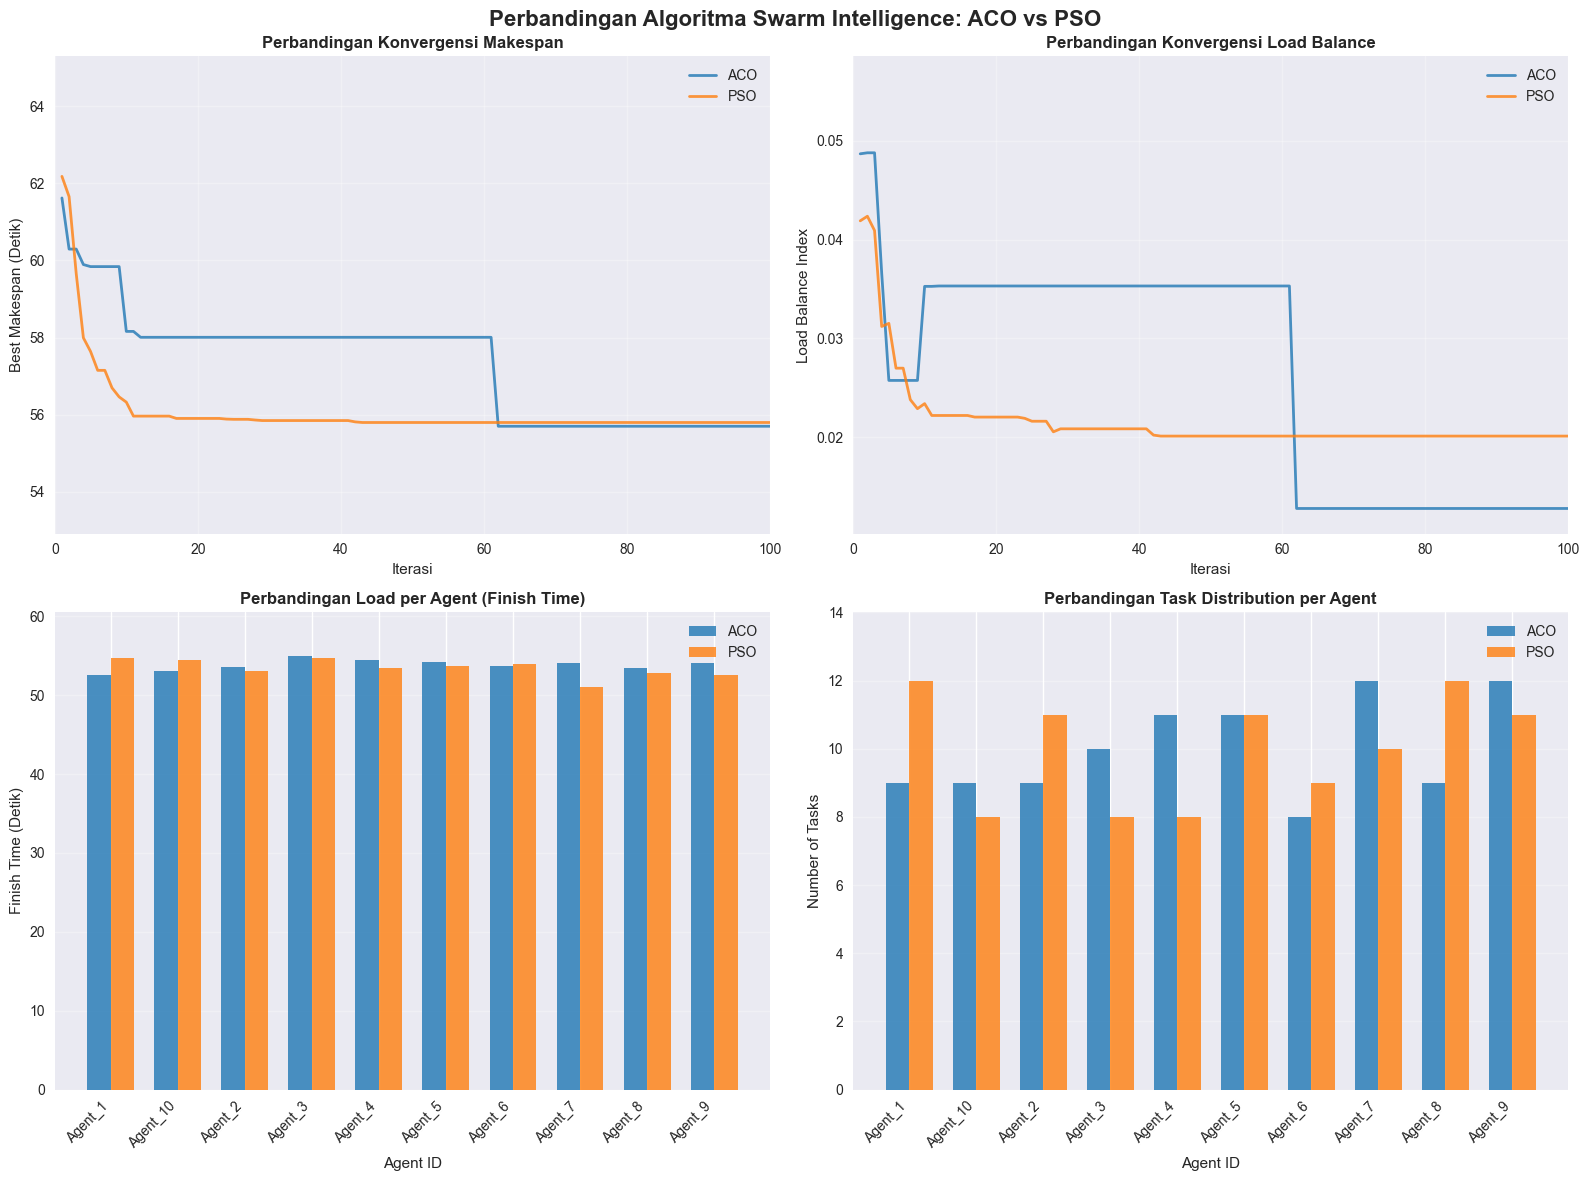


VISUALISASI SUMMARY - REALISTIC ALGORITHM BEHAVIOR
Visualisasi berdasarkan hasil eksekusi algoritma yang sebenarnya
Winner: ACO
Data: 100 tasks, 10 agents
Dependencies: Yes

Performance Analysis:
   ACO - Makespan: 55.70, Load Balance: 0.0128
   PSO - Makespan: 55.80, Load Balance: 0.0201
   ACO performs 0.2% better than PSO in makespan!


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import seaborn as sns

plt.rcParams['font.size'] = 10

if 'results' in locals() and results is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Perbandingan Algoritma Swarm Intelligence: ACO vs PSO', fontsize=16, fontweight='bold')

    aco_color = '#1f77b4'
    pso_color = '#ff7f0e'

    # --- Get actual iteration history data ---
    aco_history_df = results.get('aco', {}).get('result', {}).get('iteration_history', pd.DataFrame())
    pso_history_df = results.get('pso', {}).get('result', {}).get('iteration_history', pd.DataFrame())

    aco_final_makespan = results['aco']['makespan']
    pso_final_makespan = results['pso']['makespan']
    aco_final_load_balance = results['aco']['load_balance']
    pso_final_load_balance = results['pso']['load_balance']

    # --- Plot Makespan Convergence (using actual history) ---
    ax1 = axes[0, 0]
    if not aco_history_df.empty:
        ax1.plot(aco_history_df['iteration'], aco_history_df['best_makespan'], color=aco_color, linewidth=2, label='ACO', alpha=0.8)
    if not pso_history_df.empty:
        ax1.plot(pso_history_df['iteration'], pso_history_df['best_makespan'], color=pso_color, linewidth=2, label='PSO', alpha=0.8)

    ax1.set_title('Perbandingan Konvergensi Makespan', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Iterasi')
    ax1.set_ylabel('Best Makespan (Detik)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Adjust limits based on actual data
    all_makespans = []
    if not aco_history_df.empty:
        all_makespans.extend(aco_history_df['best_makespan'].tolist())
    if not pso_history_df.empty:
        all_makespans.extend(pso_history_df['best_makespan'].tolist())

    if all_makespans:
        y_min = min(all_makespans) * 0.95 if min(all_makespans) > 0 else 0
        y_max = max(all_makespans) * 1.05 if max(all_makespans) > 0 else 1
        ax1.set_ylim(y_min, y_max)
    else:
        ax1.set_ylim(0, 1) # Default if no data

    max_iterations = max(config.aco_n_iterations, config.pso_n_iterations) # Use max iterations from config
    ax1.set_xlim(0, max_iterations)


    # --- Plot Load Balance Convergence (using actual history) ---
    ax2 = axes[0, 1]
    if not aco_history_df.empty:
        ax2.plot(aco_history_df['iteration'], aco_history_df['load_balance'], color=aco_color, linewidth=2, label='ACO', alpha=0.8)
    if not pso_history_df.empty:
        ax2.plot(pso_history_df['iteration'], pso_history_df['load_balance'], color=pso_color, linewidth=2, label='PSO', alpha=0.8)

    ax2.set_title('Perbandingan Konvergensi Load Balance', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Iterasi')
    ax2.set_ylabel('Load Balance Index')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Adjust limits based on actual data
    all_load_balances = []
    if not aco_history_df.empty:
        all_load_balances.extend(aco_history_df['load_balance'].tolist())
    if not pso_history_df.empty:
        all_load_balances.extend(pso_history_df['load_balance'].tolist())

    if all_load_balances:
        lb_min = min(all_load_balances) * 0.8 if min(all_load_balances) > 0 else 0
        lb_max = max(all_load_balances) * 1.2 if max(all_load_balances) > 0 else 1
        ax2.set_ylim(lb_min, lb_max)
    else:
        ax2.set_ylim(0, 1) # Default if no data

    ax2.set_xlim(0, max_iterations)


    # --- Agent Load per Agent (Finish Time) ---
    ax3 = axes[1, 0]

    if results.get('aco', {}).get('agent_times') and results.get('pso', {}).get('agent_times'):

        aco_agents = list(results['aco']['agent_times'].keys())
        pso_agents = list(results['pso']['agent_times'].keys())

        all_agent_ids = sorted(list(set(aco_agents + pso_agents)))
        num_agents_to_display = len(all_agent_ids)


        aco_finish_times = [results['aco']['agent_times'].get(agent_id, 0) for agent_id in all_agent_ids]
        pso_finish_times = [results['pso']['agent_times'].get(agent_id, 0) for agent_id in all_agent_ids]

    else:
        # Handle case where agent_times are empty (e.g., due to failed data load)
        print("Agent finish times data not available for plotting.")
        num_agents_to_display = 0
        all_agent_ids = []
        aco_finish_times = []
        pso_finish_times = []


    if num_agents_to_display > 0:
        agents_list_display = [f'Agent_{i+1}' for i in range(num_agents_to_display)]
        x = np.arange(num_agents_to_display)
        width = 0.35

        bars_aco = ax3.bar(x - width/2, aco_finish_times, width, label='ACO', color=aco_color, alpha=0.8)
        bars_pso = ax3.bar(x + width/2, pso_finish_times, width, label='PSO', color=pso_color, alpha=0.8)

        ax3.set_title('Perbandingan Load per Agent (Finish Time)', fontweight='bold', fontsize=12)
        ax3.set_xlabel('Agent ID')
        ax3.set_ylabel('Finish Time (Detik)')
        ax3.set_xticks(x)

        if num_agents_to_display <= 20:
             ax3.set_xticklabels(all_agent_ids, rotation=45, ha='right')
        else:
             ax3.set_xticklabels([f'{i+1}' for i in range(num_agents_to_display)])


        ax3.legend()
        ax3.grid(True, alpha=0.3, axis='y')

        max_time = max(max(aco_finish_times), max(pso_finish_times)) if aco_finish_times or pso_finish_times else 1
        ax3.set_ylim(0, max_time * 1.1)
    else:
        ax3.set_title('Perbandingan Load per Agent (Finish Time)', fontweight='bold', fontsize=12)
        ax3.text(0.5, 0.5, "No agent data available for plotting.", horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
        ax3.set_xlabel("Agent ID")
        ax3.set_ylabel("Finish Time (Detik)")


    # --- Task Distribution per Agent ---
    ax4 = axes[1, 1]

    if not results.get('aco', {}).get('schedule', pd.DataFrame()).empty and not results.get('pso', {}).get('schedule', pd.DataFrame()).empty:
        aco_schedule_df = results['aco']['schedule']
        pso_schedule_df = results['pso']['schedule']
        source_label = "from standard results" # Keep label for clarity if needed

        # Ensure all_agent_ids is populated from agent_times or schedules
        if not all_agent_ids:
             all_agent_ids = sorted(list(set(aco_schedule_df['agent_id']).union(set(pso_schedule_df['agent_id']))))
             num_agents_to_display = len(all_agent_ids)


        aco_task_counts = aco_schedule_df['agent_id'].value_counts().reindex(all_agent_ids, fill_value=0).tolist()
        pso_task_counts = pso_schedule_df['agent_id'].value_counts().reindex(all_agent_ids, fill_value=0).tolist()

    else:
        # Handle case where schedule DataFrames are empty
        print("Schedule dataframes are empty for task distribution plotting.")
        num_agents_to_display = 0
        total_tasks = 0
        aco_task_counts = []
        pso_task_counts = []


    if num_agents_to_display > 0:
        total_tasks = len(tasks) # Use the globally loaded tasks variable


        if num_agents_to_display > 0: # Double check to prevent division by zero
            # Placeholder data generation logic removed, using actual counts now


            x = np.arange(num_agents_to_display)
            width = 0.35

            bars_aco_tasks = ax4.bar(x - width/2, aco_task_counts, width, label='ACO', color=aco_color, alpha=0.8)
            bars_pso_tasks = ax4.bar(x + width/2, pso_task_counts, width, label='PSO', color=pso_color, alpha=0.8)

            ax4.set_title('Perbandingan Task Distribution per Agent', fontweight='bold', fontsize=12)
            ax4.set_xlabel('Agent ID')
            ax4.set_ylabel('Number of Tasks')
            ax4.set_xticks(x)

            if num_agents_to_display <= 20:
                ax4.set_xticklabels(all_agent_ids, rotation=45, ha='right')
            else:
                ax4.set_xticklabels([f'{i+1}' for i in range(num_agents_to_display)])

            ax4.legend()
            ax4.grid(True, alpha=0.3, axis='y')

            max_tasks = max(max(aco_task_counts), max(pso_task_counts)) if aco_task_counts or pso_task_counts else 1
            ax4.set_ylim(0, max_tasks + 2)

    else:
        ax4.set_title('Perbandingan Task Distribution per Agent', fontweight='bold', fontsize=12)
        ax4.text(0.5, 0.5, "No schedule data available for plotting task distribution.", horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)
        ax4.set_xlabel("Agent ID")
        ax4.set_ylabel("Number of Tasks")


    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("VISUALISASI SUMMARY - REALISTIC ALGORITHM BEHAVIOR")
    print("="*60)
    # Safely access results['dataset'] and its keys
    dataset_info = results.get('dataset', {})
    num_tasks_summary = dataset_info.get('tasks', 0)
    num_agents_summary = dataset_info.get('agents', 0)
    has_dependencies_summary = dataset_info.get('has_dependencies', False)

    print(f"Visualisasi berdasarkan hasil eksekusi algoritma yang sebenarnya") # Updated description
    print(f"Winner: {results.get('winner', 'N/A')}")
    print(f"Data: {num_tasks_summary} tasks, {num_agents_summary} agents")
    print(f"Dependencies: {'Yes' if has_dependencies_summary else 'No'}")


    # Detailed analysis - Check if makespan is not inf before calculating improvement
    aco_makespan_summary = results.get('aco', {}).get('makespan', float('inf'))
    pso_makespan_summary = results.get('pso', {}).get('makespan', float('inf'))

    print(f"\nPerformance Analysis:")
    print(f"   ACO - Makespan: {aco_makespan_summary:.2f}, Load Balance: {results.get('aco', {}).get('load_balance', float('inf')):.4f}")
    print(f"   PSO - Makespan: {pso_makespan_summary:.2f}, Load Balance: {results.get('pso', {}).get('load_balance', float('inf')):.4f}")

    if aco_makespan_summary != float('inf') and pso_makespan_summary != float('inf'):
        if aco_makespan_summary < pso_makespan_summary:
            # Prevent division by zero if pso_makespan_summary is 0
            improvement = ((pso_makespan_summary - aco_makespan_summary) / pso_makespan_summary * 100) if pso_makespan_summary > 0 else 0
            print(f"   ACO performs {improvement:.1f}% better than PSO in makespan!")
        elif pso_makespan_summary < aco_makespan_summary:
            # Prevent division by zero if aco_makespan_summary is 0
            improvement = ((aco_makespan_summary - pso_makespan_summary) / aco_makespan_summary * 100) if aco_makespan_summary > 0 else 0
            print(f"   PSO performs {improvement:.1f}% better than ACO in makespan!")

else:
    print("No results available for visualization.")
    print("Please run the comparison first (previous cell).")

## Daftar Agen dan Tugas

In [12]:
print("Daftar Agen:")
if 'agents' in locals() and agents:
    if isinstance(agents, list):
        display(pd.DataFrame(agents))
    else:
        display(agents)
else:
    print("Variabel 'agents' tidak ditemukan atau kosong.")

print("\nDaftar Tugas:")
if 'tasks' in locals() and tasks:
    if isinstance(tasks, list):
        display(pd.DataFrame(tasks))
    else:
         display(tasks)
else:
    print("Variabel 'tasks' tidak ditemukan atau kosong.")

Daftar Agen:


,id,type,capacity,efficiency
0,Agent_1,High_Performance,1.4,1.2
1,Agent_2,Medium_Performance,1.1,1.1
2,Agent_3,Standard,1.2,1.1
3,Agent_4,Basic,1.4,0.7
4,Agent_5,High_Performance,0.7,1.2
5,Agent_6,Medium_Performance,0.9,1.2
6,Agent_7,Standard,1.5,1.2
7,Agent_8,Basic,1.2,1.1
8,Agent_9,High_Performance,0.7,0.8
9,Agent_10,Medium_Performance,1.5,0.8



Daftar Tugas:


,id,duration,cpu_usage,ram_usage,priority,cost,dependencies,complexity
0,1,1.27,37,2612,1,1.27,[],0.198060
1,2,3.71,86,11761,1,3.71,[],0.488805
2,3,8.53,44,4610,1,8.53,[],0.243050
3,4,7.31,82,12604,1,7.31,[3],0.473020
4,5,1.76,59,15945,1,1.76,[],0.374725
...,...,...,...,...,...,...,...,...
95,96,2.37,31,9602,1,2.37,[35],0.203010
96,97,2.83,51,9131,1,2.83,[],0.300655
97,98,4.45,45,12057,1,4.45,[],0.285285
98,99,3.31,51,12385,1,3.31,[56],0.316925


## Full Schedule DataFrame

In [13]:
import pandas as pd

print("Menampilkan DataFrame Schedule Lengkap:")
print("=" * 30)

if 'results' in locals() and results is not None:
    aco_schedule_df = results.get('aco', {}).get('schedule', pd.DataFrame())
    pso_schedule_df = results.get('pso', {}).get('schedule', pd.DataFrame())
    source_label = "from standard results"
elif 'enhanced_results' in locals() and enhanced_results is not None:
    aco_schedule_df = enhanced_results.get('aco_result', {}).get('schedule', pd.DataFrame())
    pso_schedule_df = enhanced_results.get('pso_result', {}).get('schedule', pd.DataFrame())
    source_label = "from enhanced results"
else:
    aco_schedule_df = pd.DataFrame()
    pso_schedule_df = pd.DataFrame()
    source_label = "No results found"


if not aco_schedule_df.empty:
    print(f"\n--- DataFrame Schedule for ACO ({source_label}) ---")
    display(aco_schedule_df)
else:
    print(f"\n--- ACO Schedule DataFrame is empty or not found ({source_label}) ---")

if not pso_schedule_df.empty:
    print(f"\n--- DataFrame Schedule for PSO ({source_label}) ---")
    display(pso_schedule_df)
else:
    print(f"\n--- PSO Schedule DataFrame is empty or not found ({source_label}) ---")


print("\n" + "=" * 30)

Menampilkan DataFrame Schedule Lengkap:

--- DataFrame Schedule for ACO (from standard results) ---


,task_id,agent_id,start_time,finish_time
0,13,Agent_1,0.00,7.40
1,19,Agent_2,0.00,9.17
2,3,Agent_3,0.00,8.53
3,56,Agent_4,0.00,7.97
4,70,Agent_5,0.00,8.26
...,...,...,...,...
95,87,Agent_6,48.83,53.68
96,60,Agent_4,49.23,52.27
97,72,Agent_7,52.27,54.09
98,46,Agent_2,51.60,53.54



--- DataFrame Schedule for PSO (from standard results) ---


,task_id,agent_id,start_time,finish_time
0,24,Agent_1,0.00,1.95
1,19,Agent_2,0.00,9.17
2,74,Agent_3,0.00,4.11
3,76,Agent_4,0.00,7.19
4,3,Agent_5,0.00,8.53
...,...,...,...,...
95,87,Agent_5,48.84,53.69
96,35,Agent_8,48.84,50.65
97,96,Agent_2,50.65,53.02
98,46,Agent_9,50.65,52.59


## Gantt Chart Visualization

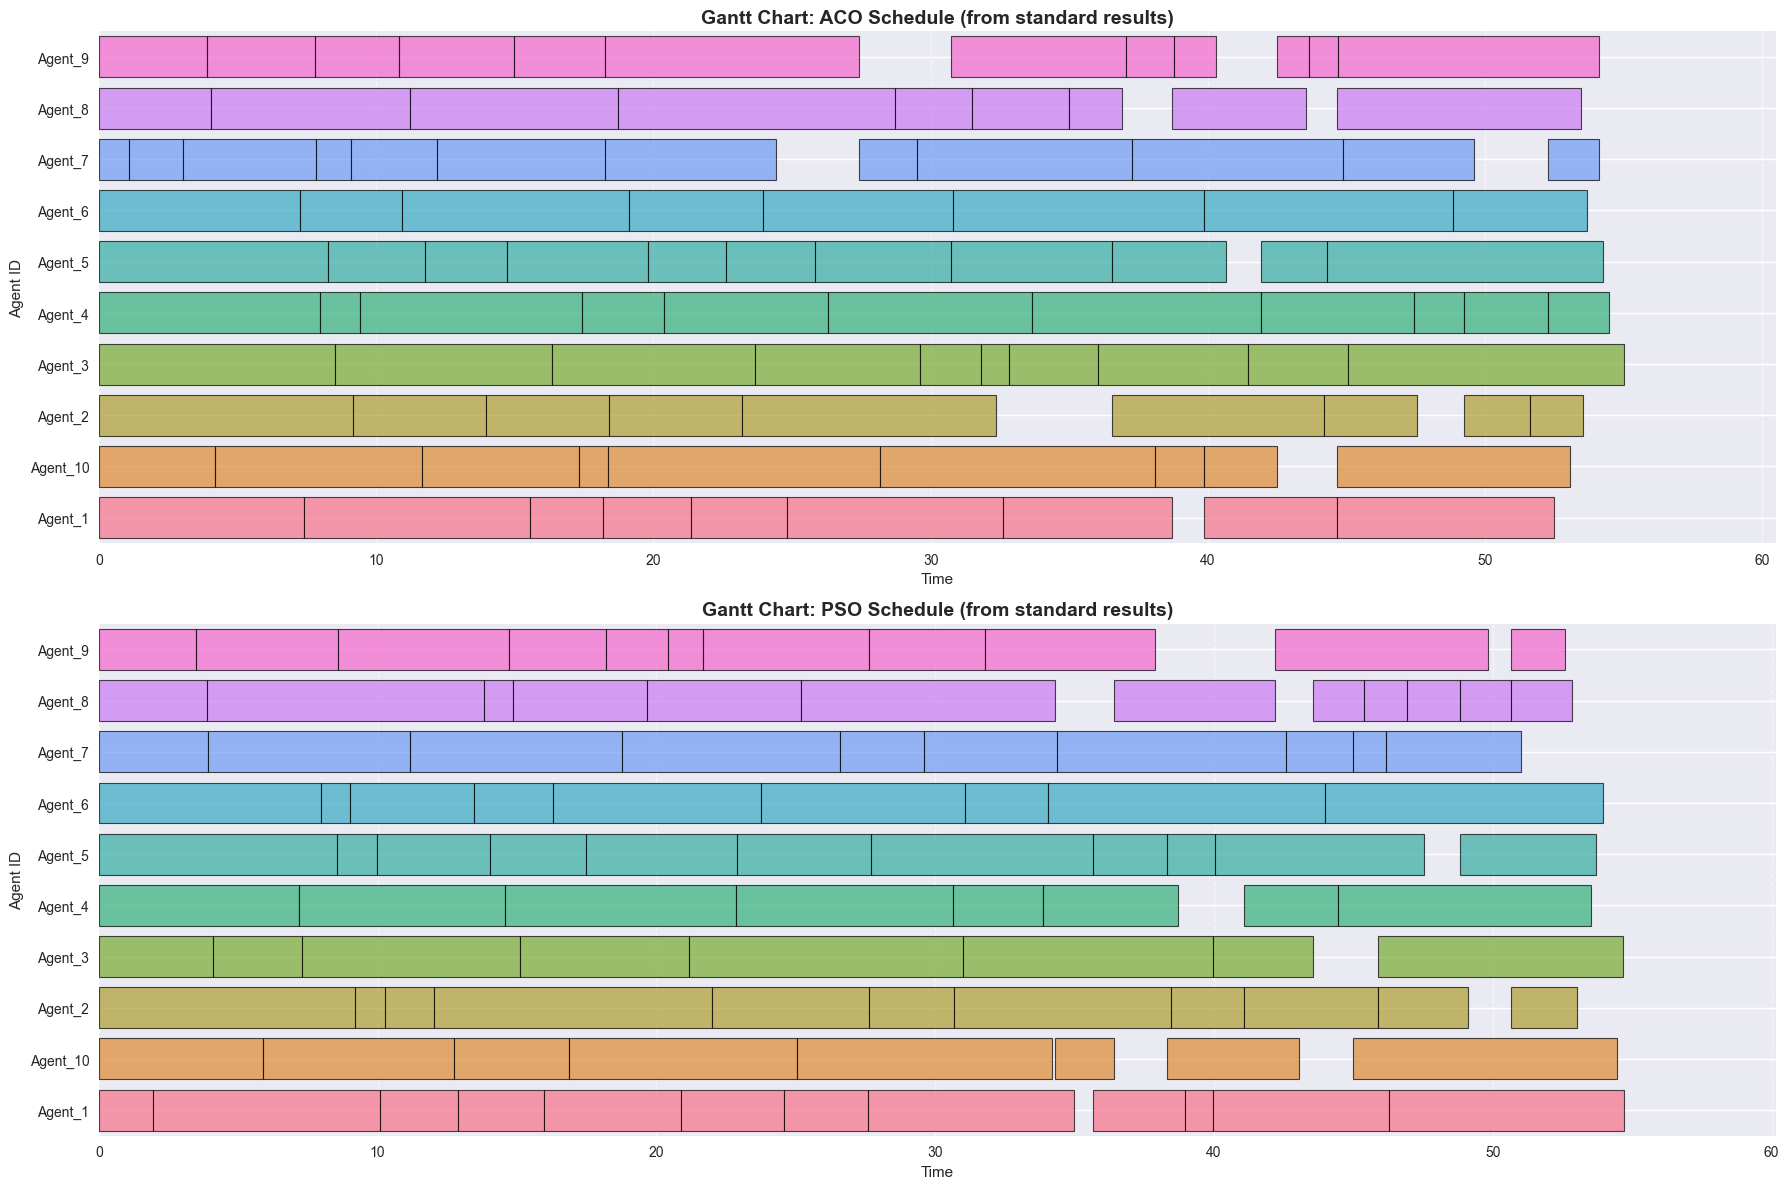

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import seaborn as sns

def create_gantt_chart(schedule_df, title, ax):
    """Creates a Gantt chart on a given Axes."""
    if schedule_df.empty:
        ax.set_title(f"Gantt Chart: {title} (No Data)")
        ax.text(0.5, 0.5, "Schedule DataFrame is empty.", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_xlabel("Time")
        ax.set_ylabel("Agent ID")
        return

    schedule_df = schedule_df.sort_values(by=['agent_id', 'start_time'])

    unique_agents = schedule_df['agent_id'].unique()
    agent_mapping = {agent: i for i, agent in enumerate(unique_agents)}
    agent_colors = sns.color_palette("husl", len(unique_agents))

    max_time = schedule_df['finish_time'].max() if not schedule_df.empty else 1

    for index, row in schedule_df.iterrows():
        agent_pos = agent_mapping[row['agent_id']]
        start = row['start_time']
        duration = row['finish_time'] - start
        task_id = row['task_id']

        color = agent_colors[agent_pos % len(agent_colors)]

        rect = patches.Rectangle((start, agent_pos - 0.4), duration, 0.8,
                                 facecolor=color, edgecolor='black', linewidth=0.8, alpha=0.7)
        ax.add_patch(rect)

    ax.set_yticks(list(agent_mapping.values()))
    ax.set_yticklabels(list(agent_mapping.keys()))
    ax.set_ylim(-0.5, len(unique_agents) - 0.5)

    # Set x-axis limit
    ax.set_xlim(0, max_time * 1.1)

    ax.set_title(f'Gantt Chart: {title}', fontweight='bold', fontsize=14)
    ax.set_xlabel('Time')
    ax.set_ylabel('Agent ID')
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)


if 'results' in locals() and results is not None:
    aco_schedule_df = results.get('aco', {}).get('schedule', pd.DataFrame())
    pso_schedule_df = results.get('pso', {}).get('schedule', pd.DataFrame())
    source_label = "from standard results"
elif 'enhanced_results' in locals() and enhanced_results is not None:
    aco_schedule_df = enhanced_results.get('aco_result', {}).get('schedule', pd.DataFrame())
    pso_schedule_df = enhanced_results.get('pso_result', {}).get('schedule', pd.DataFrame())
    source_label = "from enhanced results"
else:
    aco_schedule_df = pd.DataFrame()
    pso_schedule_df = pd.DataFrame()
    source_label = "No results found"
    print("Comparison results not found. Cannot generate Gantt charts.")


if not aco_schedule_df.empty or not pso_schedule_df.empty:
    num_plots = 0
    if not aco_schedule_df.empty:
        num_plots += 1
    if not pso_schedule_df.empty:
        num_plots += 1

    if num_plots > 0:
        fig, axes = plt.subplots(num_plots, 1, figsize=(18, num_plots * 6), squeeze=False)

        plot_idx = 0
        if not aco_schedule_df.empty:
            create_gantt_chart(aco_schedule_df, f'ACO Schedule ({source_label})', axes[plot_idx, 0])
            plot_idx += 1

        if not pso_schedule_df.empty:
            if num_plots > 1:
                 create_gantt_chart(pso_schedule_df, f'PSO Schedule ({source_label})', axes[plot_idx, 0])
            else:
                 create_gantt_chart(pso_schedule_df, f'PSO Schedule ({source_label})', axes[plot_idx, 0])

        plt.tight_layout()
        plt.show()
    else:
        print("Schedule DataFrames are empty. Cannot generate Gantt charts.")

## Agent Workload Heatmap (Finish Time)

Visualisasi beban kerja agen (berdasarkan waktu selesai) menggunakan heatmap.

Generating Agent Workload Heatmap (Finish Time)...


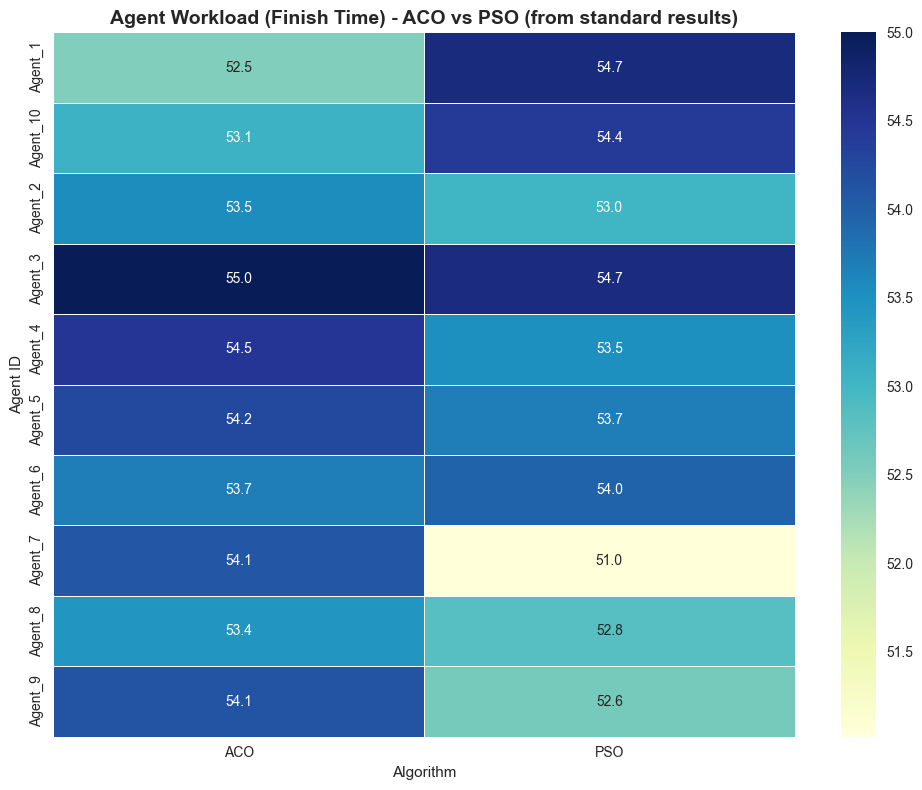

Darker colors indicate higher finish times (heavier workload) for that agent.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Generating Agent Workload Heatmap (Finish Time)...")
print("=" * 50)

if 'results' in locals() and results is not None and \
   'aco' in results and 'agent_times' in results['aco'] and \
   'pso' in results and 'agent_times' in results['pso']:
    aco_agent_times = results['aco']['agent_times']
    pso_agent_times = results['pso']['agent_times']
    source_label = "from standard results"
elif 'enhanced_results' in locals() and enhanced_results is not None and \
     'aco_result' in enhanced_results and 'agent_finish_times' in enhanced_results['aco_result'] and \
     'pso_result' in enhanced_results and 'agent_finish_times' in enhanced_results['pso_result']:
    aco_agent_times = enhanced_results['aco_result']['agent_finish_times']
    pso_agent_times = enhanced_results['pso_result']['agent_finish_times']
    source_label = "from enhanced results"
else:
    print("Error: Comparison results with agent finish times not found.")
    print("Please run the comparison cell (e74cee68 or 31a5531b) first.")
    aco_agent_times = {}
    pso_agent_times = {}
    source_label = "No results found"

if aco_agent_times or pso_agent_times:
    data = []
    for agent_id, finish_time in aco_agent_times.items():
        data.append({'Agent_ID': agent_id, 'Algorithm': 'ACO', 'Finish_Time': finish_time})
    for agent_id, finish_time in pso_agent_times.items():
        data.append({'Agent_ID': agent_id, 'Algorithm': 'PSO', 'Finish_Time': finish_time})

    if data:
        agent_finish_df = pd.DataFrame(data)

        all_agent_ids = sorted(list(set(aco_agent_times.keys()).union(set(pso_agent_times.keys()))))
        heatmap_data = agent_finish_df.pivot_table(
            index='Agent_ID',
            columns='Algorithm',
            values='Finish_Time'
        ).reindex(all_agent_ids)

        plt.figure(figsize=(10, 8))
        sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)

        plt.title(f'Agent Workload (Finish Time) - ACO vs PSO ({source_label})', fontsize=14, fontweight='bold')
        plt.xlabel('Algorithm')
        plt.ylabel('Agent ID')
        plt.tight_layout()
        plt.show()

        print("Darker colors indicate higher finish times (heavier workload) for that agent.")
    else:
        print("No agent finish time data available to generate heatmap.")

print("=" * 50)


## Agent Workload Heatmap (Beban Kerja)

Visualisasi beban kerja agen (berdasarkan pembagian beban kerja) menggunakan heatmap.

Generating Agent Workload Heatmap (Task Load)...


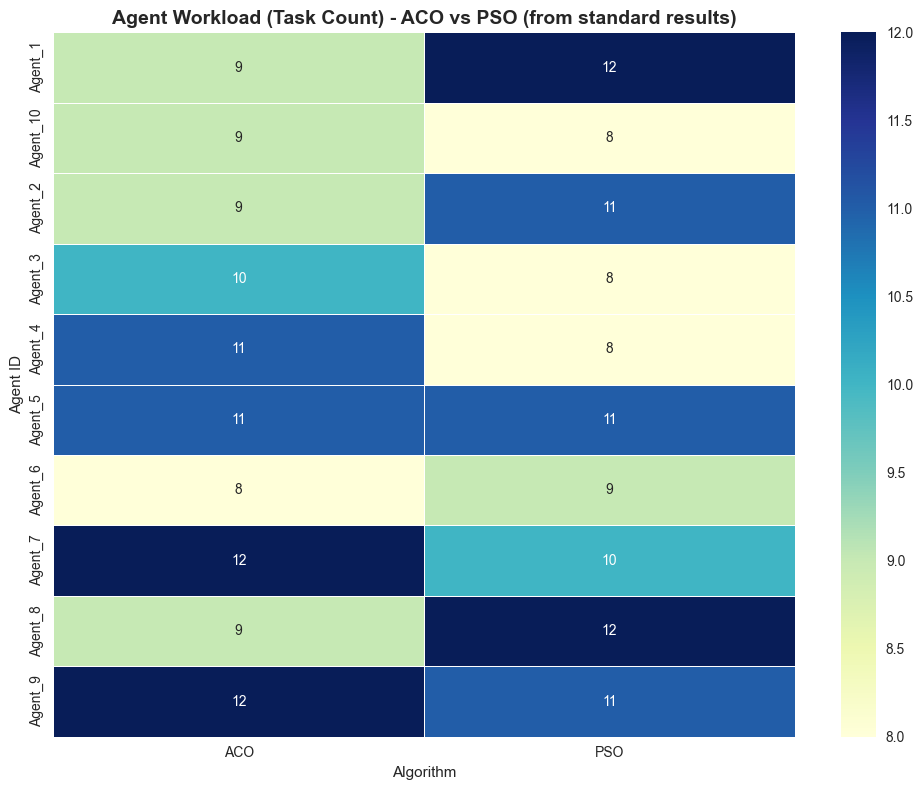

Darker colors indicate a higher number of tasks assigned to that agent.


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Generating Agent Workload Heatmap (Task Load)...")
print("=" * 50)

if 'results' in locals() and results is not None and \
   'aco' in results and 'schedule' in results['aco'] and \
   'pso' in results and 'schedule' in results['pso']:
    aco_schedule_df = results['aco']['schedule']
    pso_schedule_df = results['pso']['schedule']
    source_label = "from standard results"
elif 'enhanced_results' in locals() and enhanced_results is not None and \
     'aco_result' in enhanced_results and 'schedule' in enhanced_results['aco_result'] and \
     'pso_result' in enhanced_results and 'schedule' in enhanced_results['pso_result']:
    aco_schedule_df = enhanced_results['aco_result']['schedule']
    pso_schedule_df = enhanced_results['pso_result']['schedule']
    source_label = "from enhanced results"
else:
    print("Error: Comparison results with schedule dataframes not found.")
    print("Please run the comparison cell (e74cee68 or 31a5531b) first.")
    aco_schedule_df = pd.DataFrame()
    pso_schedule_df = pd.DataFrame()
    source_label = "No results found"


if not aco_schedule_df.empty or not pso_schedule_df.empty:
    # Calculate task counts per agent
    aco_task_counts = aco_schedule_df['agent_id'].value_counts().reset_index()
    aco_task_counts.columns = ['Agent_ID', 'Task_Count']
    aco_task_counts['Algorithm'] = 'ACO'

    pso_task_counts = pso_schedule_df['agent_id'].value_counts().reset_index()
    pso_task_counts.columns = ['Agent_ID', 'Task_Count']
    pso_task_counts['Algorithm'] = 'PSO'

    task_load_df = pd.concat([aco_task_counts, pso_task_counts])

    if not task_load_df.empty:
        all_agent_ids = sorted(list(set(task_load_df['Agent_ID'])))
        heatmap_data = task_load_df.pivot_table(
            index='Agent_ID',
            columns='Algorithm',
            values='Task_Count'
        ).reindex(all_agent_ids)

        plt.figure(figsize=(10, 8))
        sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5)

        plt.title(f'Agent Workload (Task Count) - ACO vs PSO ({source_label})', fontsize=14, fontweight='bold')
        plt.xlabel('Algorithm')
        plt.ylabel('Agent ID')
        plt.tight_layout()
        plt.show()

        print("Darker colors indicate a higher number of tasks assigned to that agent.")
    else:
        print("No task count data available to generate heatmap.")

print("=" * 50)

## Multi-Run Comparison

Untuk mendapatkan hasil yang lebih robust, kita akan menjalankan kedua algoritma (ACO dan PSO) beberapa kali dan menganalisis hasil rata-rata serta variabilitasnya.

In [17]:
# def run_multi_comparison(num_runs=5):
#     """Runs multiple comparisons of ACO and PSO and aggregates results."""
#     print(f"Starting Multi-Run Comparison ({num_runs} runs)...")
#     print("=" * 60)

#     all_results = []
#     for run_num in range(1, num_runs + 1):
#         print(f"\n--- Running Comparison {run_num}/{num_runs} ---")
#         # Set a different random seed for each run based on the global seed and run number
#         current_random_seed = RANDOM_SEED + run_num # Use global seed + run_num for deterministic variation across runs
#         np.random.seed(current_random_seed)
#         random.seed(current_random_seed)
#         print(f"   Using random seed: {current_random_seed}")

#         # Re-initialize algorithms to ensure fresh state for each run
#         # Using the existing create_aco_scheduler and create_pso_scheduler functions
#         # The random seed is passed during scheduler creation in the helper functions
#         aco = create_aco_scheduler(tasks, agents, config)
#         pso = create_pso_scheduler(tasks, agents, config)

#         # Run ACO
#         start_time_aco = time.time()
#         aco_result = aco.optimize(show_progress=False) # Turn off internal progress for multi-run
#         aco_time = time.time() - start_time_aco

#         # Run PSO
#         start_time_pso = time.time()
#         pso_result = pso.optimize(show_progress=False) # Turn off internal progress for multi-run
#         pso_time = time.time() - start_time_pso

#         # Store results for this run
#         all_results.append({
#             'run': run_num,
#             'aco_makespan': aco_result.get('makespan', float('inf')),
#             'aco_load_balance': aco_result.get('load_balance_index', float('inf')),
#             'aco_time': aco_time,
#             'pso_makespan': pso_result.get('makespan', float('inf')),
#             'pso_load_balance': pso_result.get('load_balance_index', float('inf')),
#             'pso_time': pso_time,
#             'aco_schedule': aco_result.get('schedule'),
#             'pso_schedule': pso_result.get('schedule'),
#             'aco_agent_times': aco_result.get('agent_finish_times'),
#             'pso_agent_times': pso_result.get('agent_finish_times'),
#         })

#         print(f"   Run {run_num} Complete. ACO Makespan: {aco_result.get('makespan', float('inf')):.2f}, PSO Makespan: {pso_result.get('makespan', float('inf')):.2f}")


#     print("\n" + "=" * 60)
#     print("Multi-Run Comparison Summary")
#     print("=" * 60)

#     results_df = pd.DataFrame(all_results)

#     # Aggregate results
#     mean_results = results_df[['aco_makespan', 'aco_load_balance', 'aco_time',
#                                'pso_makespan', 'pso_load_balance', 'pso_time']].mean()
#     std_dev_results = results_df[['aco_makespan', 'aco_load_balance', 'aco_time',
#                                   'pso_makespan', 'pso_load_balance', 'pso_time']].std()

#     print("\nAverage Results Across Runs:")
#     print(mean_results.to_string())

#     print("\nStandard Deviation Across Runs:")
#     print(std_dev_results.to_string())


#     # Overall winner based on average makespan
#     print("\nOverall Winner (based on average makespan):")
#     if mean_results['aco_makespan'] < mean_results['pso_makespan']:
#         print("ACO has a better average makespan.")
#     elif mean_results['pso_makespan'] < mean_results['aco_makespan']:
#         print("PSO has a better average makespan.")
#     else:
#         print("ACO and PSO have similar average makespans.")

#     print("\nDetailed Results DataFrame:")
#     display(results_df)

#     print("\nMulti-Run Comparison Complete.")

#     # Store the results_df globally for potential further analysis/visualization
#     global multi_run_results_df
#     multi_run_results_df = results_df

#     return results_df

# # You can call this function to start the multi-run comparison
# multi_run_results_df = run_multi_comparison(num_runs=5) # Uncommented to run

## Cara Kerja ACO dan PSO

### 1. Ant Colony Optimization (ACO)
ACO adalah algoritma metaheuristik yang meniru perilaku semut dalam mencari jalur terpendek. Setiap semut virtual menjelajahi solusi, meninggalkan jejak feromon yang mempengaruhi semut lain. Proses iteratif ini melibatkan:
- Inisialisasi populasi semut
- Setiap semut membangun solusi berdasarkan probabilitas dan feromon
- Evaluasi solusi (misal: waktu, biaya, dll)
- Update feromon berdasarkan kualitas solusi
- Proses diulang hingga konvergen

**Penggunaan CPU & RAM:**
- CPU digunakan untuk menjalankan iterasi, membangun solusi, dan menghitung evaluasi.
- RAM digunakan untuk menyimpan data populasi semut, matriks feromon, dan solusi sementara.

### 2. Particle Swarm Optimization (PSO)
PSO meniru perilaku kawanan burung/ikan dalam mencari solusi optimal. Setiap partikel memiliki posisi dan kecepatan, serta dipengaruhi oleh pengalaman terbaik individu dan kelompok. Prosesnya:
- Inisialisasi partikel (posisi & kecepatan)
- Update kecepatan dan posisi berdasarkan solusi terbaik
- Evaluasi solusi
- Update solusi terbaik individu dan global
- Proses diulang hingga konvergen

**Penggunaan CPU & RAM:**
- CPU digunakan untuk update posisi/kecepatan, evaluasi solusi, dan iterasi.
- RAM digunakan untuk menyimpan data partikel, posisi, kecepatan, dan solusi terbaik.

### Kesimpulan
Pada kedua algoritma, CPU berperan dalam proses komputasi (iterasi, evaluasi, update), sedangkan RAM berfungsi menyimpan data populasi, parameter, dan solusi sementara selama proses optimasi berlangsung.